In [278]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
from abc import ABC, abstractmethod
import math
import re
from scipy.optimize import minimize
from itertools import product
import seaborn as sns
from matplotlib import animation

# Define force field

In [2]:
def harmonic_PE(r, k, r0):
    """
    Computes harmonic potential energy

    Parameters:
        r: separation distance
        k: spring constant
        r0: equilibrium bond length

    Returns:
        Harmonic potential energy
    """
    return 0.5 * k * ((r-r0)**2)

def harmonic_force(r_vec, k, r0):
    """
    Computes the magnitude of the force due to the harmonic bond potential.

    Parameters:
        r_vec: displacement vector
        k: spring constant
        r0: equilibrium bond length

    Returns:
        Magnitude of the force due to the harmonic bond potential
    """
    r = np.linalg.norm(r_vec)
    r = np.clip(r, a_min=1e-12, a_max=None)
    return -k * (r-r0) * r_vec / r

well_coeff = 2**(1/6)
def repulsive_lj(r, sigma, epsilon):
    """
    Computes the repulsive Lennard-Jones potential energy.

    Parameters:
        r: separation distance
        sigma: distance where the potential energy is 0
        epsilon: well depth

    Returns:
        lj potential energy
    """
    if r < well_coeff*sigma:
        r = np.clip(r, a_min=1e-12, a_max=None)
        sixth_pow = (sigma/r) ** 6
        return 4 * epsilon * (sixth_pow**2 - sixth_pow + 1/4)
    else:
        return 0

def repulsive_lj_force(r_vec, sigma, epsilon):
    """
    Computes the force due to repulsive Lennard-Jones potential energy.

    Parameters:
        r_vec: displacement vector
        sigma: distance where the potential energy is 0
        epsilon: well depth

    Returns:
        force due to lj potential energy
    """
    r = np.linalg.norm(r_vec)
    if r < well_coeff*sigma:
        r = np.clip(r, a_min=1e-12, a_max=None)
        sixth_pow = (sigma/r) ** 6
        return -24*epsilon/r * (sixth_pow - 2*(sixth_pow**2)) * r_vec / r
    else:
        return np.zeros_like(r_vec)

def attractive_lj(r, sigma, epsilon):
    """
    Computes the attractive Lennard-Jones potential energy.

    Parameters:
        r: separation distance
        sigma: distance where the potential energy is 0
        epsilon: well depth

    Returns:
        lj potential energy
    """
    r = np.clip(r, a_min=1e-12, a_max=None)
    sixth_pow = (sigma/r) ** 6
    return 4 * epsilon * (sixth_pow**2 - sixth_pow)

def attractive_lj_force(r_vec, sigma, epsilon):
    """
    Computes the force due to attractive Lennard-Jones potential energy.

    Parameters:
        r_vec: displacement vector
        sigma: distance where the potential energy is 0
        epsilon: well depth

    Returns:
        force due to lj potential energy
    """
    r = np.linalg.norm(r_vec)
    r = np.clip(r, a_min=1e-12, a_max=None)
    sixth_pow = (sigma/r) ** 6
    return -24*epsilon/r * (sixth_pow - 2*(sixth_pow**2)) * r_vec / r

# Unit cell

In [3]:
class OrthorhombicCell():
    """
    Stores particle information in a orthorombic cell
    with periodic boundary conditions and minimum image convention
    """
    def __init__(self, a, b, c, n, masses, connectivity):
        """
        OrthorhombicCell(a, b, c, n, connectivity)

        Parameters:
            a, b, c: parameters of the cell
            n: number of particles in the cell
            masses: masses of particles
            connectivity:
                adjacency list of the bond connectivity of the particles.
                connectivity[i] is the list of indices for atoms bonded to atom i (0-based index)
        """
        self.dim = np.array([a, b, c])
        self.n = n
        self.masses = masses
        self.adj_list = connectivity
        self.positions = np.zeros((n, 3))
        self.bonded = None
        self.repulsive = None
        self.attractive = None
        # map of two-bond connectivity
        adj_list_2 = []
        for i in range(self.n):
            cur_list = []
            neighbors = self.adj_list[i]
            for neighbor in neighbors:
                for second_neighbor in self.adj_list[neighbor]:
                    if second_neighbor != i and second_neighbor not in neighbors:
                        cur_list.append(second_neighbor)
            adj_list_2.append(cur_list)
        self.adj_list_2 = adj_list_2

    def set_positions(self, positions):
        """
        Sets the positions of the atoms.

        Parameters:
            positions: np.array with shape self.n * 3
        """
        np.copyto(self.positions, positions)
    
    def wrap(self):
        """
        Wraps the particles into the cell by applying the pbc
        """
        self.positions %= self.dim

    def update_positions(self, delta_positions):
        """
        Add delta_positions to current positions and wrap in cell.

        Parameters:
            delta_positions: np.array with shape self.n * 3
        """
        self.positions += delta_positions
        self.wrap()

    def get_displacement_from_i_to_j(self, i, j):
        """
        Calculates displacement from atoms i to atom j with mic

        Parameters:
            i, j: int|array, indices of atoms

        Returns:
            An array of displacement vectors from atoms i to j under mic
        """
        r_vec = self.positions[j] - self.positions[i]
        r_mic = r_vec - self.dim*np.round(r_vec/self.dim)
        if r_mic.ndim == 1:
            r_mic = r_mic.reshape(1, -1)
        return r_mic

    def get_distances_between(self, i, j):
        """
        Calculates distance between atoms i and j with mic

        Parameters:
            i, j: int|array, indices of atoms

        Returns:
            An array of distances between atoms i and j under mic
        """
        r_mic = self.get_displacement_from_i_to_j(i, j)
        return np.linalg.norm(r_mic, axis=1)

    def unwrap(self):
        """
        Unwraps the particles onto the infinite lattice space
        by sequentially placing bonded atoms onto their closest image
        to the central atom. Implemented using depth-first search.
        """
        visited = np.zeros(self.n, dtype=bool)
        for i in range(self.n):
            if visited[i]:
                continue
            visited[i] = True
            visit_stack = [i]
            while (len(visit_stack)>0):
                cur_idx = visit_stack.pop()
                neighbors = self.adj_list[cur_idx]
                for neighbor_idx in neighbors:
                    if visited[neighbor_idx]:
                        continue
                    visit_stack.append(neighbor_idx)
                    visited[neighbor_idx] = True
                    r_vec = self.positions[neighbor_idx] - self.positions[cur_idx]
                    self.positions[neighbor_idx] -= self.dim*np.round(r_vec/self.dim)

    def inject_energy(self, bonded, repulsive, attractive):
        """
        Injects energy functions as dependencies.

        Parameters:
            bonded: calculates bonded potential energy. bonded(r)
            repulsive: calculates repulsive potential energy. repulsive(r)
            attractive: calculates attractive potential energy. attractive(r)
        """
        self.bonded = bonded
        self.repulsive = repulsive
        self.attractive = attractive

    def calc_PE_between(self, i, j, r):
        """
        Calculates potential energy between atoms i and j according to their connectivity.

        Parameters:
            i, j: integer indices of a pair of atoms
            r: distance between atoms i and j

        Returns:
            potential energy
        """
        if j == i:
            return 0 # self
        elif j in self.adj_list[i]:
            return self.bonded(r) # one bond
        elif j in self.adj_list_2[i]:
            return self.repulsive(r) # two bonds
        else:
            return self.attractive(r)

    def get_PE(self):
        """
        Gets the potential energy of the system with mic.
        """
        pe = 0
        for i in range(self.n):
            atom1 = np.array([i for _ in range(i+1, self.n)], dtype=int)
            atom2 = np.array(range(i+1, self.n), dtype=int)
            rs = self.get_distances_between(atom1, atom2)
            for j, r in zip(atom2, rs):
                pe += self.calc_PE_between(i, j, r)
        return pe

    def inject_force(self, bonded_f, repulsive_f, attractive_f):
        """
        Injects force functions as dependencies.

        Parameters:
            bonded_f: calculates bonded potential energy. bonded(r_vec)
            repulsive_f: calculates repulsive potential energy. repulsive(r_vec)
            attractive_f: calculates attractive potential energy. attractive(r_vec)
        """
        self.bonded_f = bonded_f
        self.repulsive_f = repulsive_f
        self.attractive_f = attractive_f

    def calc_force_i_on_j(self, i, j, r_vec):
        """
        Calculates the force on atom j from atom i according to their connectivity.

        Parameters:
            i, j: integer indices of a pair of atoms
            r_vec: displacement vector from atom i to j

        Returns:
            a vector of force with same shape as r_vec
        """
        if j == i: # self
            return np.zeros_like(r_vec)
        elif j in self.adj_list[i]: # one bond
            return self.bonded_f(r_vec) 
        elif j in self.adj_list_2[i]: # two bonds
            return self.repulsive_f(r_vec)
        else:
            return self.attractive_f(r_vec)

    def get_forces(self):
        """
        Gets the forces of the system in N with mic.

        Returns:
            A n*3 array of forces on each particle in the system.
        """
        forces = np.zeros_like(self.positions)
        for i in range(self.n):
            atom1 = np.array([i for _ in range(i+1, self.n)], dtype=int)
            atom2 = np.array(range(i+1, self.n), dtype=int)
            r_vecs = self.get_displacement_from_i_to_j(atom1, atom2)
            for j, r_vec in zip(atom2, r_vecs):
                f = self.calc_force_i_on_j(i, j, r_vec)
                forces[j] += f
                forces[i] -= f
                
        return forces

    def get_centroid(self):
        """
        Gets the centroid of the molecule.

        Returns:
            centroid of the molecule
        """
        return np.mean(self.positions, axis=0)

    def center_in_box(self, inplace=False):
        """
        Centers the molecule in box by first unwrapping it,
        moves its centroid to the box center, then wrap again.

        Parameters:
            inplace: if set to True, updates positions in place.

        Returns:
            Centered positions
        """
        self.unwrap()
        cent = self.get_centroid()
        box_center = self.dim / 2
        new_pos = self.positions + box_center - cent
        new_pos %= self.dim
        if inplace:
            np.copyto(self.positions, new_pos)
        return new_pos

    def plot_atoms(self, ax, center=True, size=1, title=None, xlim=None):
        """
        Plots the atoms in the cell.

        Parameters:
            ax: plotting axis
            center: if the molecule should be centered in the box
            size: controls the size of the sphere
            title: title of the plot
            xlim: (xmin, xmax) sets the axes limits
        """
        def plot_sphere(center, r):
            u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
            x = r*np.cos(u)*np.sin(v) + center[0]
            y = r*np.sin(u)*np.sin(v) + center[1]
            z = r*np.cos(v) + center[2]
            ax.plot_surface(x, y, z, alpha=0.6, color='r')

        self.wrap()
        if center:
            positions = self.center_in_box(inplace=False)
        else:
            positions = self.positions

        r = 0.03 * size * (self.dim[0]*self.dim[1]*self.dim[2])**(1/3)
        for coor in positions:
            plot_sphere(coor, r)

        for i, neighbors in enumerate(self.adj_list):
            for j in neighbors:
                if j > i:
                    xs = [positions[i, 0], positions[j, 0]]
                    ys = [positions[i, 1], positions[j, 1]]
                    zs = [positions[i, 2], positions[j, 2]]
                    ax.plot(xs, ys, zs, color='grey')
        ax.set_box_aspect([1,1,1])
        if xlim is None:
            xmin = np.min(positions) - 2*r
            xmax = np.max(positions) + 2*r
        else:
            xmin, xmax = xlim
        ax.set_xlim(xmin, xmax); ax.set_xticklabels([])
        ax.set_ylim(xmin, xmax); ax.set_yticklabels([])
        ax.set_zlim(xmin, xmax); ax.set_zticklabels([])
        if title is None:
            title = "Molecular Configuration"
        ax.set_title(title)

    def write_psf(self, filename):
        """
        Writes a .psf file to the given file path.

        Parameters:
            filename: name of the output file
        """
        with open(filename, 'w') as file:
            file.write("PSF\n\n")
            file.write("       1 !NTITLE\n")
            file.write(" REMARKS coarse-grained polymer chain\n\n")

            file.write(f"{self.n:8d} !NATOM\n")
            for i, m in zip(range(1, self.n+1), self.masses):
                # index segid resid resname atomname atomtype charge mass
                file.write(
                    f"{i:8d} POLY   1 POL  CG    CG    0.000  {m:3.3f}\n"
                )
            file.write("\n")

            n_bonds = 0
            for i in range(self.n):
                for j in self.adj_list[i]:
                    if j > i:
                        n_bonds += 1
            file.write(f"{n_bonds:8d} !NBOND: bonds\n")
            n_bonds = 0
            for i in range(self.n):
                for j in self.adj_list[i]:
                    if j > i:
                        file.write(f"{i+1:8d}{i+2:8d}")
                        n_bonds += 1
                        if (n_bonds % 4 == 0):
                            file.write("\n")
            file.write("\n")

## QC

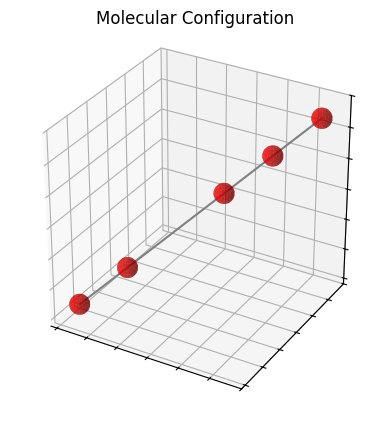

In [261]:
test = OrthorhombicCell(
    10, 10, 10, 5, [1, 1, 1, 1, 1],
    [[1],
     [0, 2],
     [1, 3],
     [2, 4],
     [3]
    ])
test.set_positions([[-1,-1,-1], [0,0,0], [2,2,2], [3,3,3], [4,4,4]])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
test.plot_atoms(ax, size=1, center=True)

In [356]:
test.write_psf('topology/test.psf')

In [262]:
test.inject_energy(
    lambda r: 1,
    lambda r: 2,
    lambda r: 3
)
test.get_PE()

19

In [358]:
k = 1.0
epsilon_repulsive = 1.0

r0 = 1.0
epsilon_attractive = 0.5
sigma = 1.0
test.inject_energy(
    lambda r: harmonic_PE(r, k, r0),
    lambda r: repulsive_lj(r, sigma, epsilon_repulsive),
    lambda r: attractive_lj(r, sigma, epsilon_attractive)
)
test.get_PE()

np.float64(3.839705052771677)

# Simulation Class

In [4]:
class VelocityRescalingThermostat():
    """
    Velocity rescaling thermostat
    """
    def __init__(self, target_T, m):
        """
        VelocityRescalingThermostat(target_T, m)

        Parameters:
            target_T: target temperature
            m: array of masses of the particles
        """
        self.target_T = target_T
        self.masses = m
        self.n = m.shape[0]

    def dial_to(self, target_T):
        """
        Resets the target temperature
        
        Parameters:
            target_T: target temperature
        """
        self.target_T = target_T
    
    def __call__(self, v):
        """
        Rescales the temperature.

        Parameters:
            v: 2D array of velocities
        """
        KE = 1/2*np.sum((self.masses * (np.linalg.norm(v, axis=1)**2)))
        cur_temp = 2/3 * KE / self.n
        v *= np.sqrt(self.target_T / cur_temp)

In [5]:
class MDSimulation(ABC):
    """
    Molecular Dynamics Simulation.
    """
    box = None
    timestep = None
    velocities = None
    n = 0
    masses = None
    step = 0
    rescale_interval = None
    thermostat = None
    
    def set_force_field(self, forces, potentials):
        """
        Injects force field functions.

        Parameters:
            forces: dict of force functions. f(r_vec)
            potentials: dict of potential functions. f(r)
            Both must contain keys 'bonded', 'attractive' and 'repulsive'.
        """
        self.box.inject_force(forces['bonded'], forces['repulsive'], forces['attractive'])
        self.box.inject_energy(potentials['bonded'], potentials['repulsive'], potentials['attractive'])

    @abstractmethod
    def init_velocities(self, temp):
        """
        Initializes and sets the particle velocities 
        by drawing from the Maxwell-Boltzmann distribution and thermostating.
        Sets the thermostat to the provided temperature.

        Parameters:
            temp: temperature of the system
        """
        pass
        
    @abstractmethod
    def init_simulation(
        self,
        forces, potentials,
        gamma, dmd_max_steps, convergence,
        em_max_steps, force_tol, energy_tol,
        heating_n_steps, eq_n_steps
    ):
        """
        Initializes the system for simulation.

        Parameters:
            forces: dict of force functions. f(r_vec)
            potentials: dict of potential functions. f(r)
                Both must contain keys 'bonded', 'attractive' and 'repulsive'.
            gamma: dampening coefficient for velocities
            dmd_max_steps: max number of steps to run damped md
            em_max_steps: max steps to run energy minimization
            force_tol: force tolerance
            energy_tol: energy tolerance
            convergence: convergence threshold for potential difference
            heating_n_steps: number of steps to heat up the system to target temperature
            eq_n_steps: number of equilibration steps
        """
        pass
    
    def run(self):
        """
        Runs one time step of the MD simulation.
        """
        self.step += 1
        masses = self.masses.reshape(n, 1)
        
        forces = self.box.get_forces()
        dv = 0.5 * forces / masses * self.timestep
        self.velocities += dv
        self.box.update_positions(self.velocities * self.timestep)
        forces = self.box.get_forces()
        dv = 0.5 * forces / masses * self.timestep
        self.velocities += dv

        if self.step % self.rescale_interval == 0:
            self.thermostat(self.velocities)

    def em(self, max_steps=2000, force_tol=1e-3, energy_tol=1e-6):
        """
        Runs energy minimization.

        Parameters:
            max_steps: max steps to run
            force_tol: force tolerance
            energy_tol: energy tolerance
        """
        if self.verbose:
            print("Starting energy minimization...")
            pbar = tqdm(total=None, desc="EM")
        def objective(coords):
            self.box.set_positions(coords.reshape(self.box.positions.shape))
            self.box.wrap()
            pe = self.box.get_PE()
            if self.verbose:
                pbar.update(1)
                pbar.set_description(f"Potential = {pe:.2f}")
            return (pe, -self.box.get_forces().ravel())

        coords = minimize(
            objective,
            self.box.positions.ravel(),
            method='L-BFGS-B',
            jac=True,
            options = {
                'maxiter': max_steps,
                'gtol': force_tol,
                'ftol': energy_tol
            }
        )
        if self.verbose:
            print(f"EM {"succeeded" if coords.success else "failed"} after {coords.nit} iterations with PE = {coords.fun:.2f}")
        self.box.set_positions(coords.x.reshape((self.n, 3)))
        self.box.wrap()

    def damped_md(self, gamma=0.5, max_steps=5000, convergence = 1e-10):
        """
        Runs damped MD energy minimization to minimize potential energy.

        parameters:
            gamma: dampening coefficient for velocities
            max_steps: max number of steps to run
            convergence: convergence threshold for potential difference
        """
        if self.verbose:
            print(f"Starting damped MD on {self.n} atoms...")
        masses = self.masses.reshape(n, 1)
        self.velocities = np.zeros_like(self.box.positions)
        last_PE = self.box.get_PE()
        
        forces = self.box.get_forces()
        dv = 0.5 * forces / masses * self.timestep
        self.velocities += dv * gamma
        self.box.update_positions(self.velocities * self.timestep)
        forces = self.box.get_forces()
        dv = 0.5 * forces / masses * self.timestep * gamma
        self.velocities += dv
        cur_PE = self.box.get_PE()

        cur_step = 0
        if self.verbose:
            pbar = tqdm(total=None, desc="DMD")
        while (cur_step <= max_steps and (cur_PE > last_PE or last_PE - cur_PE > convergence)):
            last_PE = cur_PE
            forces = self.box.get_forces()
            dv = 0.5 * forces / masses * self.timestep
            self.velocities += dv * gamma
            self.box.update_positions(self.velocities * self.timestep)
            forces = self.box.get_forces()
            dv = 0.5 * forces / masses * self.timestep * gamma
            self.velocities += dv
            cur_PE = self.box.get_PE()

            cur_step += 1
            if self.verbose:
                pbar.update(1)
                pbar.set_description(f"Potential = {cur_PE:.2f}")
        if self.verbose:
            if cur_step > max_steps:
                print(f"Max itr exceeded with potential difference {last_PE - cur_PE:.2f}")
            else:
                print(f"Converged after {cur_step} iterations with potential difference {last_PE - cur_PE:.2f}")

    def heat(self, heating_n_steps=5000):
        """
        Heats up the system gradually to the target temperature.

        Parameters:
            heating_n_steps: number of steps to heat up the system to target temperature
        """
        if self.verbose:
            print("Heating up the system...")
            pbar = tqdm(total=heating_n_steps)
        temp_start = self.temp / heating_n_steps
        self.init_velocities(temp_start)
        masses = self.masses.reshape(n, 1)
        for temp in np.linspace(temp_start, self.temp, num=heating_n_steps):
            self.thermostat.dial_to(temp)
        
            forces = self.box.get_forces()
            dv = 0.5 * forces / masses * self.timestep
            self.velocities += dv
            self.box.update_positions(self.velocities * self.timestep)
            forces = self.box.get_forces()
            dv = 0.5 * forces / masses * self.timestep
            self.velocities += dv

            self.thermostat(self.velocities)
            if self.verbose:
                pbar.update(1)
                pbar.set_description(f"Tempearture = {temp:.2f}")
        if self.verbose:
            print(f"Finished heating, temperature = {self.temp:.2f}, PE = {self.box.get_PE():.2f}")

In [6]:
class CoarseGrainPolymerChain(MDSimulation):
    """
    Simulation for a coarse grain polymer chain.
    """
    def init_particles(self, r0):
        """
        Initalizes the particle positions.

        Parameters:
            r0 (angstrom): bond length

        Returns:
            (positions, conn)
            positions: array of initialized positions
            conn: adjacency list of particle connectivity
        """
        conn = [[] for _ in range(self.n)]
        positions = np.zeros((self.n, 3))
        positions[0] = np.array([self.a/2, self.a/2, self.a/2])
        for i in range(1, self.n):
            direction = self.rng.random(3)*2 - 1
            direction /= np.linalg.norm(direction)
            positions[i] = positions[i-1] + r0*direction
            conn[i-1].append(i)
            conn[i].append(i-1)
        return positions, conn

    def init_velocities(self, temp):
        """
        Initializes and sets the particle velocities 
        by drawing from the Maxwell-Boltzmann distribution and thermostating.

        Parameters:
            temp: temperature of the system
        """
        std = np.sqrt(temp / self.masses[0])
        velocities = self.rng.normal(loc=0, scale=std, size=(self.n, 3))
        velocities -= np.mean(velocities, axis=0) # rid of net momentum
        self.velocities = velocities
        self.thermostat(self.velocities) # refit to target temp

    def init_box(self):
        """
        Initializes the unit cell.
        """
        positions, conn = self.init_particles(self.r0)
        self.box = self.box_class(a, a, a, n, self.masses, conn)
        self.box.set_positions(positions)
        self.box.wrap()

    def init_simulation(
        self, forces, potentials, 
        gamma=0.05, dmd_max_steps=100, convergence=1e-2, 
        em_max_steps=2000, force_tol=1e-3, energy_tol=1e-6,
        heating_n_steps=5000, eq_n_steps=5000
    ):
        self.init_box()
        self.set_force_field(forces, potentials)
        # prevent overlap
        self.damped_md(gamma=gamma, max_steps=dmd_max_steps, convergence=convergence)
        # energy minimization
        self.em(max_steps=em_max_steps, force_tol=force_tol, energy_tol=energy_tol)
        # heat up to target temperature
        self.heat(heating_n_steps=heating_n_steps)
        # equilibration
        self.thermostat.dial_to(self.temp)
        self.init_velocities(self.temp)
        self.step = 0
        if self.verbose:
            print("Starting equilibration...")
        if self.verbose:
            i_range = tqdm(range(eq_n_steps))
        else:
            i_range = range(eq_n_steps)
        for i in i_range:
            self.run()
        if self.verbose:
            print(f"Ended equilibration with PE = {self.box.get_PE():.2f}")
            print("System ready for production!")
        self.step = 0
    
    def __init__(
        self, 
        n, a, masses, r0, temp, box, timestep, 
        thermostat, rescale_interval, rng,
        verbose=True
    ):
        """
        CoarseGrainPolymerChain(n, masses, box, timestep, thermostat, rescale_interval)

        Parameters:
            n: number of particles
            a (angstrom): cubic box length
            masses (g/mol): int|array masses of particles
            r0 (angstrom): bond length of the polymer chain
            temp (K): target temperature
            box: a Cell class
            timestep (fs): simulation time step
            thermostat: a Thermostat class
            rescale_interval: number of steps to run between thermostating
            rng: random number generator
            verbose: sets verbose output
        """
        self.rng = rng
        self.n = n
        self.a = a
        self.r0 = r0
        self.masses = np.array(masses)
        if (len(self.masses.shape) == 0):
            self.masses = np.array([masses for _ in range(self.n)])
        self.timestep = timestep
        self.rescale_interval = rescale_interval
        self.temp = temp
        self.step = 0
        self.box_class = box
        self.thermostat = thermostat(temp, self.masses)
        self.verbose = verbose

## QC

In [391]:
k = 1.0
epsilon_repulsive = 0.1

rng = np.random.default_rng(114514)
n = 30
a = 30
mass = 1
timestep = 0.01
r0 = 1.0
epsilon_attractive = 0.5
sigma = 1.0
temp = 0.1
rescale_interval = 100

chain = CoarseGrainPolymerChain(
    n=n, a=a, masses=mass, r0=r0, temp=temp, 
    box=OrthorhombicCell, timestep=timestep, 
    thermostat=VelocityRescalingThermostat,
    rescale_interval=rescale_interval, rng=rng
)

In [392]:
potentials = {
    "bonded": lambda r: harmonic_PE(r, k, r0),
    "repulsive": lambda r: repulsive_lj(r, sigma, epsilon_repulsive),
    "attractive": lambda r: attractive_lj(r, sigma, epsilon_attractive)
}
forces = {
    "bonded": lambda r_vec: harmonic_force(r_vec, k, r0),
    "attractive": lambda r_vec: repulsive_lj_force(r_vec, sigma, epsilon_repulsive),
    "repulsive": lambda r_vec: attractive_lj_force(r_vec, sigma, epsilon_attractive)
}
gamma = 0.0001
dmd_max_steps = 20
convergence = 1e-2
em_max_steps = 200
force_tol = 1e-6
energy_tol = 1e-3
heating_n_steps = 20
eq_n_steps = 20
chain.init_simulation(
    forces, potentials,
    gamma=gamma, dmd_max_steps = dmd_max_steps, convergence = convergence,
    em_max_steps=em_max_steps, force_tol=force_tol, energy_tol=energy_tol,
    heating_n_steps = heating_n_steps,
    eq_n_steps = eq_n_steps
)

Starting damped MD on 30 atoms...


DMD: 0it [00:00, ?it/s]

Max itr exceeded with potential difference 94.00
Starting energy minimization...


EM: 0it [00:00, ?it/s]

EM succeeded after 46 iterations with PE = -8.64
Heating up the system...


  0%|          | 0/20 [00:00<?, ?it/s]

Finished heating, temperature = 0.10, PE = -8.67
Starting equilibration...


  0%|          | 0/20 [00:00<?, ?it/s]

Ended equilibration with PE = -9.02
System ready for production!


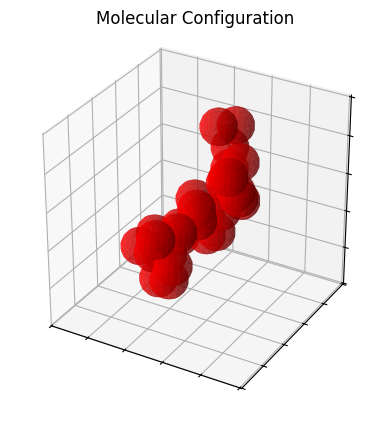

In [372]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
chain.box.plot_atoms(ax)

In [373]:
chain.box.get_PE()

np.float64(-9.016797524467334)

In [374]:
def write_traj(filename, frames):
    N = frames[0].shape[0]
    with open(filename, "w") as f:
        for pos in frames:
            f.write(f"{N}\nframe\n")
            for x, y, z in pos:
                f.write(f"CG {x:.6f} {y:.6f} {z:.6f}\n")

In [92]:
n_frames = 100
n_writes = 8
interval = n_frames//n_writes

top = "topology/chain0.psf"
traj = "trajectory/chain0.xyz"
chain.box.write_psf(top)
frames = []
for i in tqdm(range(n_frames)):
    chain.run()
    if i%interval == 0:
        frames.append(chain.box.positions.copy())
write_traj(traj, frames)

  0%|          | 0/100 [00:00<?, ?it/s]

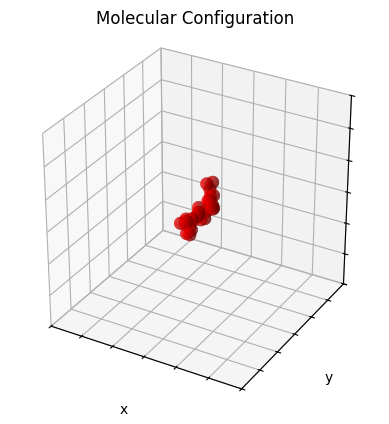

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
chain.box.plot_atoms(ax, center=True)

In [94]:
chain.box.get_PE()

np.float64(-10.602042076741917)

# Analysis Class

In [154]:
class Universe():
    """
    Universe of a simulation system.
    """
    def __init__(
        self, box, a, b, c, forces, potentials,
        top=None, traj=None, frames=None, masses=None, conn=None
    ):
        """
        Universe(box, a, b, c, forces, potentials, top, traj, positions, conn)
        Initializes the system, either with top and traj or with frames, masses and conn.

        Parameters:
            box: the unit cell class
            a, b, c: dimensions of the unit cell
            forces: dict of force functions. f(r_vec)
            potentials: dict of potential functions. f(r)
                Both must contain keys 'bonded', 'attractive' and 'repulsive'.
            
            top: path to topology file
            traj: path to trajectory file
            ----------------------------------
            frames: list of positions for each frame
            masses: masses of atoms
            conn: adjacency list of connectivity of the atoms
        """
        self.is_center = False
        self.frames = None
        self.conn = None
        self.masses = None
        self.n = 0
        self.n_frames = 0
        self.box_class = box
        self.a = a; self.b = b; self.c = c
        self.cur_step = 0
        self.forces = forces
        self.potentials = potentials
        
        if frames:
            self.frames = frames
            self.n_frames = len(frames)
            self.conn = conn
            self.masses = masses
            self.n = len(self.masses)
            self.set_step(0)
            return
        
        atoms_line = re.compile(r'(\d+)\s+!NATOM')
        atoms = re.compile(r'(\d+)\s+\w+\s+\d+\s+\w+\s+\w+\s+\w+\s+\d+.\d+\s+(\d+.\d+)')
        bonds_line = re.compile(r'(\d+)\s+!NBOND:\s+bonds')
        with open(top, 'r') as file:
            line = file.readline()
            while line:
                atoms_group = atoms_line.search(line)
                if atoms_group:
                    n_atoms = int(atoms_group.group(1))
                    self.n = n_atoms
                    self.masses = np.zeros(self.n)
                    self.conn = [[] for _ in range(self.n)]
                    for i in range(n_atoms):
                        line = file.readline()
                        atom_group = atoms.search(line)
                        idx = int(atom_group.group(1)) - 1
                        mass = float(atom_group.group(2))
                        self.masses[idx] = mass
                else:
                    bonds_group = bonds_line.search(line)
                    if bonds_group:
                        n_bonds = int(bonds_group.group(1))
                        for i in range(math.ceil(n_bonds/4)):
                            bonds = file.readline().strip().split()
                            for j in range(0, len(bonds), 2):
                                x = int(bonds[j]) - 1
                                y = int(bonds[j+1]) - 1
                                self.conn[x].append(y)
                                self.conn[y].append(x)
                line = file.readline()
        self.traj = traj
        with open(self.traj, 'r') as file:
            for line in file:
                if line.strip().lower() == 'frame':
                    self.n_frames += 1
        self.set_step(0)

    def center(self):
        """
        Centers the atoms in the unit cell.
        """
        self.is_center = True
    
    def set_step(self, i):
        """
        Sets the current positions at step i of the trajectory.
        """
        if i >= self.n_frames:
            raise ValueError(f"Index {i} out of bounds for a trajectory with {self.n_frames} frames")
        if i < 0:
            i = self.n_frames + i
        self.cur_step = i
        
        self.box = self.box_class(self.a, self.b, self.c, self.n, self.masses, self.conn)
        self.box.inject_force(self.forces['bonded'], self.forces['repulsive'], self.forces['attractive'])
        self.box.inject_energy(self.potentials['bonded'], self.potentials['repulsive'], self.potentials['attractive'])
        
        if self.frames:
            self.box.set_positions(self.frames[i])
            self.box.wrap()
            return
            
        pos_line = re.compile(r'\w+\s+(\d+.\d+)\s+(\d+.\d+)\s+(\d+.\d+)')
        positions = np.zeros((self.n, 3))
        with open(self.traj, 'r') as file:
            n_frames = -1
            while n_frames < i:
                line = file.readline()
                if line.strip().lower() == 'frame':
                    n_frames += 1
            for j in range(self.n):
                line = file.readline().strip()
                pos = pos_line.search(line)
                x = float(pos.group(1)); y = float(pos.group(2)); z = float(pos.group(3));
                positions[j] = np.array([x, y, z], dtype=float)
        self.box.set_positions(positions)
        if self.is_center:
            self.box.center_in_box(inplace=True)
        else:
            self.box.wrap()

    def get_center_of_mass(self):
        """
        Calculates the center of mass of the system.
        """
        masses = self.masses.reshape((self.n, 1))
        return np.mean(masses * self.box.positions, axis=0)

    def get_avg_bond_length(self):
        """
        Calculates the average bond length.
        """
        bonds = []
        for i in range(self.n-1):
            for j in self.box.adj_list[i]:
                if j > i:
                    bonds.append(np.linalg.norm(self.box.positions[j] - self.box.positions[i]))
        return np.mean(bonds)

    def get_radius_of_gyration(self):
        """
        Calculates the radius of gyration of the system.
        """
        com = self.get_center_of_mass()
        rg = np.mean(
            np.linalg.norm(self.box.positions - com, axis=-1)**2
        )
        return np.sqrt(rg)

    def get_end_to_end_distance(self):
        """
        Calculates the end-to-end distance of the system.
        """
        return np.linalg.norm(self.box.positions[-1] - self.box.positions[0])

    def get_PE(self):
        """
        Calculates the potential energy of the system.
        """
        return self.box.get_PE()

    def get_max_dist(self, mic=False):
        """
        Gets the maximum distance between any pair of atoms in the system.

        Parameters:
            mic: if True, use minimum image convention.
        """
        pairs = []
        for i in range(self.n-1):
            for j in range(i+1, self.n):
                pairs.append([i, j])
        pairs = np.array(pairs)
        if mic:
            dist = self.box.get_distances_between(pairs[:, 0], pairs[:, 1])
        else:
            pos1 = self.box.positions[pairs[:, 0]]
            pos2 = self.box.positions[pairs[:, 1]]
            dist = np.linalg.norm(pos2 - pos1, axis = -1)
        return np.max(dist)

    def plot(self, ax, center=True, size=1, title=None, xlim=None):
        """
        Plots the atoms in the cell.

        Parameters:
            ax: plotting axis
            center: if the molecule should be centered in the box
            size: controls the size of the sphere
            title: title of the plot
            xlim: (xmin, xmax) sets the axes limits
        """
        self.box.plot_atoms(ax, center, size, title, xlim)

## QC

In [ ]:
u = Universe(
    OrthorhombicCell, 30, 30, 30, forces, potentials,
    "topology/chain0.psf", "trajectory/chain0.xyz"
)

In [34]:
u.n_frames

9

In [35]:
u.set_step(-1)
print(u.cur_step)
u.box.positions

Trajectory at time 8
8


array([[14.424216, 15.218561, 15.565457],
       [13.999335, 14.320596, 15.64471 ],
       [14.531962, 14.275807, 14.953862],
       [15.222906, 14.050904, 14.259143],
       [14.552068, 14.361422, 13.828708],
       [14.784828, 13.773309, 13.343212],
       [14.844608, 13.215021, 13.756719],
       [15.381016, 12.818336, 14.097345],
       [15.836791, 12.634254, 13.700236],
       [15.880962, 12.738612, 13.016417],
       [15.592771, 13.455745, 12.732337],
       [14.952433, 12.54087 , 12.448784],
       [13.717092, 11.923529, 11.524703],
       [12.754904, 11.322083, 10.542475],
       [11.649323, 11.178818, 10.301495],
       [11.974801, 12.116568, 10.594346],
       [13.038651, 12.399441, 10.619573],
       [14.026488, 12.710407, 10.772202],
       [14.790731, 12.438643, 11.32055 ],
       [14.043381, 12.783567, 11.911364],
       [13.769981, 12.527031, 12.734067],
       [14.182831, 11.753183, 12.499223],
       [14.617224, 10.968052, 12.618893],
       [14.240867,  9.887622, 12.4

In [114]:
print(u.get_radius_of_gyration())
print(u.get_end_to_end_distance())
print(u.get_PE())

6.774786444340977
8.018084370646207
-9.039682695586494


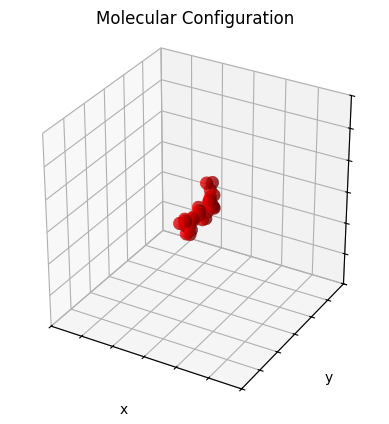

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
u.plot(ax)

# Run Simulation

In [9]:
def parameterize_force_field(k, epsilon_repulsive):
    """
    Parameterize the force field.

    Parameters:
        k: spring constant
        epsilon_repulsive: repulsive LJ well depth

    Returns:
        tuple of parameterized (forces, potentials)
    """
    r0 = 1.0
    epsilon_attractive = 0.5
    sigma = 1.0
    forces = {
        "bonded": lambda r_vec: harmonic_force(r_vec, k, r0),
        "attractive": lambda r_vec: attractive_lj_force(r_vec, sigma, epsilon_attractive),
        "repulsive": lambda r_vec: repulsive_lj_force(r_vec, sigma, epsilon_repulsive)
    }
    potentials = {
        "bonded": lambda r: harmonic_PE(r, k, r0),
        "repulsive": lambda r: repulsive_lj(r, sigma, epsilon_repulsive),
        "attractive": lambda r: attractive_lj(r, sigma, epsilon_attractive)
    }
    return forces, potentials

In [10]:
def write_traj(filename, frames):
    N = frames[0].shape[0]
    with open(filename, "w") as f:
        for pos in frames:
            f.write(f"{N}\nframe\n")
            for x, y, z in pos:
                f.write(f"CG {x:.6f} {y:.6f} {z:.6f}\n")

In [11]:
def run_md(n, a, temp, forces, potenitals, n_steps, save_interval, top, traj, rng):
    """
    Runs the MD simulation.

    Parameters:
        n: number of atoms to simulate
        a: cubic cell dimensions
        temp: simulation temperature
        forces: dict of force functions. f(r_vec)
        potentials: dict of potential functions. f(r)
            Both must contain keys 'bonded', 'attractive' and 'repulsive'.
        n_steps: number of simulation steps
        save_interval: number of steps between saves. Set to None for to disable saving.
        top: path to topology file
        traj: path to trajectory file
        rng: random number generator
    """
    r0 = 1.0
    mass = 1
    timestep = 0.01
    rescale_interval = 100
    
    chain = CoarseGrainPolymerChain(
        n=n, a=a, masses=mass, r0=r0, temp=temp, 
        box=OrthorhombicCell, timestep=timestep, 
        thermostat=VelocityRescalingThermostat,
        rescale_interval=rescale_interval, rng=rng,
        verbose=False
    )
    
    gamma = 0.0001
    dmd_max_steps = 100
    convergence = 1e-2
    em_max_steps = 200
    force_tol = 1e-6
    energy_tol = 1e-3
    heating_n_steps = 500
    eq_n_steps = 1000
    chain.init_simulation(
        forces, potentials,
        gamma=gamma, dmd_max_steps=dmd_max_steps, convergence=convergence,
        em_max_steps=em_max_steps, force_tol=force_tol, energy_tol=energy_tol,
        heating_n_steps=heating_n_steps,
        eq_n_steps=eq_n_steps
    )

    if save_interval is not None:
        chain.box.write_psf(top)
    frames = []
    for i in range(n_steps):
        chain.run()
        if save_interval is not None and i % save_interval == 0:
            frames.append(chain.box.positions.copy())
    if save_interval is not None:
        write_traj(traj, frames)

In [12]:
def scan_temperatures(batch, temps, n, a, forces, potenitals, n_steps, save_interval, top, traj, rng):
    """
    Runs MD on each of the given temperatures

    Parameters:
        batch: number of batches to run
        temps: list of simulation temperatures
        n: number of atoms to simulate
        a: cubic cell dimensions
        forces: dict of force functions. f(r_vec)
        potentials: dict of potential functions. f(r)
            Both must contain keys 'bonded', 'attractive' and 'repulsive'.
        n_steps: number of simulation steps
        save_interval: number of steps between saves. Set to None for to disable saving.
        top: path to topology file
        traj: path to trajectory file
        rng: random number generator
    """
    top_prefix = ""
    top_postfix = ""
    traj_prefix = ""
    traj_postfix = ""
    file_name_regex = re.compile(r"^(.+)\.(.+)$")
    if save_interval is not None:
        grp = file_name_regex.match(top)
        top_prefix = grp.group(1)
        top_postfix = grp.group(2)
        grp = file_name_regex.match(traj)
        traj_prefix = grp.group(1)
        traj_postfix = grp.group(2)

    pbar = tqdm(total = batch*len(temps))
    for i in range(batch):
        for temp in temps:
            run_md(
                n, a, temp, forces, potenitals, n_steps, save_interval,
                f"{top_prefix}_{temp}-temp_{i}-batch.{top_postfix}",
                f"{traj_prefix}_{temp}-temp_{i}-batch.{traj_postfix}",
                rng
            )
            pbar.update(1)
    pbar.close()

In [15]:
rng = np.random.default_rng(114514)

In [16]:
temps = np.round(np.linspace(0.1, 1.0, 6), 2)
n = 20
a = 100
epsilon_repulsives = np.round(np.linspace(0.1, 2.0, 6), 2)
ks = np.round(np.linspace(1.0, 100.0, 6), 2)
batch = 3

for epsilon_repulsive in epsilon_repulsives:
    print(epsilon_repulsive)
    for k in ks:
        n_steps = 10001
        save_interval = 10
        forces, potentials = parameterize_force_field(k, epsilon_repulsive)
        file_prefix = f"chain_{n}-atoms_{k}-spring_{epsilon_repulsive}-er"
        scan_temperatures(
            batch, temps, n, a, forces, potentials, n_steps, save_interval,
            f"topology/{file_prefix}.psf",
            f"trajectory/{file_prefix}.xyz",
            rng
        )

0.1


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

0.48


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

0.86


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

1.24


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

1.62


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

2.0


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [88]:
rng = np.random.default_rng(114514)
temps = np.round(np.linspace(0.1, 1.0, 6), 2)
epsilon_repulsive = 1.24
k = 1.0
batch_1 = 3
batch_2 = 1
ns = [5, 10, 40, 80]
a_s = [25, 50, 200, 400]

for n, a in zip(ns, a_s):
    print(n)
    n_steps = 10001
    save_interval = 10
    forces, potentials = parameterize_force_field(k, epsilon_repulsive)
    file_prefix = f"chain_{n}-atoms_{k}-spring_{epsilon_repulsive}-er"
    batch = 0
    if n < 20:
        batch = batch_1
    else:
        batch = batch_2
    scan_temperatures(
        batch, temps, n, a, forces, potentials, n_steps, save_interval,
        f"topology/{file_prefix}.psf",
        f"trajectory/{file_prefix}.xyz",
        rng
    )

5


  0%|          | 0/18 [00:00<?, ?it/s]

10


  0%|          | 0/18 [00:00<?, ?it/s]

40


  0%|          | 0/6 [00:00<?, ?it/s]

80


  0%|          | 0/6 [00:00<?, ?it/s]

In [177]:
rng = np.random.default_rng(114514)
temps = np.round(np.linspace(0.1, 1.0, 6), 2)
epsilon_repulsive = 1.24
k = 100.0
batch_1 = 3
batch_2 = 1
ns = [5, 10, 40, 80]
a_s = [25, 50, 200, 400]

for n, a in zip(ns, a_s):
    print(n)
    n_steps = 10001
    save_interval = 10
    forces, potentials = parameterize_force_field(k, epsilon_repulsive)
    file_prefix = f"chain_{n}-atoms_{k}-spring_{epsilon_repulsive}-er"
    batch = 0
    if n < 20:
        batch = batch_1
    else:
        batch = batch_2
    scan_temperatures(
        batch, temps, n, a, forces, potentials, n_steps, save_interval,
        f"topology/{file_prefix}.psf",
        f"trajectory/{file_prefix}.xyz",
        rng
    )

5


  0%|          | 0/18 [00:00<?, ?it/s]

10


  0%|          | 0/18 [00:00<?, ?it/s]

40


  0%|          | 0/6 [00:00<?, ?it/s]

80


  0%|          | 0/6 [00:00<?, ?it/s]

# Analysis

In [28]:
def load_universe(n, a, k, epsilon_repulsive, temp, batch):
    file_prefix = f"chain_{n}-atoms_{k}-spring_{epsilon_repulsive}-er_{temp}-temp_{int(batch)}-batch"
    forces, potentials = parameterize_force_field(k, epsilon_repulsive)
    u = Universe(
        OrthorhombicCell, a, a, a, forces, potentials,
        f"topology/{file_prefix}.psf",
        f"trajectory/{file_prefix}.xyz"
    )
    return u

In [29]:
n = 20
a = 100
epsilon_repulsives = np.round(np.linspace(0.1, 2.0, 6), 2)
ks = np.round(np.linspace(1.0, 100.0, 6), 2)
temps = np.round(np.linspace(0.1, 1.0, 6), 2)
batches = [0, 1, 2]

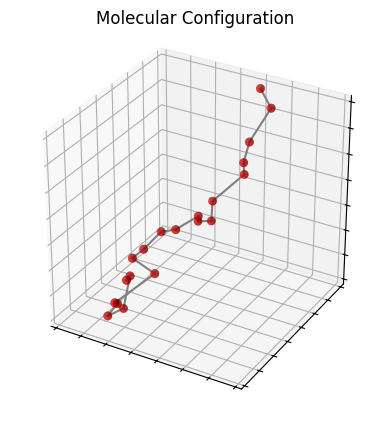

In [30]:
u = load_universe(n, a, ks[0], epsilon_repulsives[0], temps[-1], batches[0])
u.set_step(-1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
u.plot(ax, size=0.1)

In [31]:
u.n_frames

1001

In [220]:
n = 20
a = 100
all_params = np.array(list(product(temps, ks, epsilon_repulsives, batches)))
uni_df = pd.DataFrame({
    'temp': all_params[:, 0],
    'k': all_params[:, 1],
    'epsilon_repulsive': all_params[:, 2],
    'batch': all_params[:, 3]
})
uni_df['batch'] = uni_df['batch'].astype(int)
uni_df['u'] = uni_df.apply(
    lambda row: load_universe(n, a, row.k, row.epsilon_repulsive, row.temp, row.batch),
    axis=1
)
uni_df['u'].apply(lambda x: x.center())
uni_df

temp      k  epsilon_repulsive  batch  \
0     0.1    1.0               0.10      0   
1     0.1    1.0               0.10      1   
2     0.1    1.0               0.10      2   
3     0.1    1.0               0.48      0   
4     0.1    1.0               0.48      1   
..    ...    ...                ...    ...   
643   1.0  100.0               1.62      1   
644   1.0  100.0               1.62      2   
645   1.0  100.0               2.00      0   
646   1.0  100.0               2.00      1   
647   1.0  100.0               2.00      2   

                                                    u  
0    <__main__.Universe object at 0x0000025EFDAE62A0>  
1    <__main__.Universe object at 0x0000025E82B51CA0>  
2    <__main__.Universe object at 0x0000025E82B88440>  
3    <__main__.Universe object at 0x0000025E82B88560>  
4    <__main__.Universe object at 0x0000025E82B89520>  
..                                                ...  
643  <__main__.Universe object at 0x0000025E86A70A10>  
644  <__main__.Universe object at 0x0000025E86A70B60>  
645  <__main__.Universe object at 0x0000025E86A70CB0>  
646  <__main__.Universe object at 0x0000025E86A70E00>  
647  <__main__.Universe object at 0x0000025E86A70F50>  

[648 rows x 5 columns]

In [33]:
def average_properties(func, stepper, steps, pbar=None):
    """
    Averages the computation over steps.

    Parameters:
        func: a callable object that returns a numeric property
        stepper: a callable object that sets the current step
        steps: array of steps
        pbar: progress bar
    """
    results = []
    for step in steps:
        stepper(step)
        results.append(func())
    results = np.array(results)
    if pbar:
        pbar.update(1)
    return np.mean(results, axis=-1)

In [35]:
steps = np.arange(951, 1001, dtype=int)
pbar = tqdm(total=len(uni_df)*3)
uni_df['Rg'] = uni_df['u'].apply(
    lambda u: average_properties(u.get_radius_of_gyration, u.set_step, steps, pbar)
)
uni_df['Re'] = uni_df['u'].apply(
    lambda u: average_properties(u.get_end_to_end_distance, u.set_step, steps, pbar)
)
uni_df['PE'] = uni_df['u'].apply(
    lambda u: average_properties(u.get_PE, u.set_step, steps, pbar)
)

  0%|          | 0/1944 [00:00<?, ?it/s]

In [36]:
uni_df = uni_df.drop(columns='u')
uni_df

temp      k  epsilon_repulsive  batch        Rg        Re         PE
0     0.1    1.0               0.10      0  1.087250  2.745282 -36.109590
1     0.1    1.0               0.10      1  1.055093  2.272770 -36.999584
2     0.1    1.0               0.10      2  1.050977  1.161705 -37.848285
3     0.1    1.0               0.48      0  1.033539  1.964449 -39.002718
4     0.1    1.0               0.48      1  1.055323  1.184700 -38.295526
..    ...    ...                ...    ...       ...       ...        ...
643   1.0  100.0               1.62      1  2.179350  4.196108   7.002401
644   1.0  100.0               1.62      2  2.434229  5.027902   7.953218
645   1.0  100.0               2.00      0  2.808171  6.327784   8.170254
646   1.0  100.0               2.00      1  2.682843  6.382640   8.642857
647   1.0  100.0               2.00      2  2.836413  7.536388   8.550454

[648 rows x 7 columns]

## Visualization

In [241]:
u1_df = uni_df.query('temp==0.1 and k==1.0 and batch==0')
u1_df = pd.concat([u1_df, uni_df.query('temp==1.0 and k==1.0 and batch==0')])
u1_df

temp    k  epsilon_repulsive  batch  \
0     0.1  1.0               0.10      0   
3     0.1  1.0               0.48      0   
6     0.1  1.0               0.86      0   
9     0.1  1.0               1.24      0   
12    0.1  1.0               1.62      0   
15    0.1  1.0               2.00      0   
540   1.0  1.0               0.10      0   
543   1.0  1.0               0.48      0   
546   1.0  1.0               0.86      0   
549   1.0  1.0               1.24      0   
552   1.0  1.0               1.62      0   
555   1.0  1.0               2.00      0   

                                                    u  
0    <__main__.Universe object at 0x0000025EFDAE62A0>  
3    <__main__.Universe object at 0x0000025E82B88560>  
6    <__main__.Universe object at 0x0000025E82B70F50>  
9    <__main__.Universe object at 0x0000025E82B73BC0>  
12   <__main__.Universe object at 0x0000025E82B726F0>  
15   <__main__.Universe object at 0x0000025E80A6CAD0>  
540  <__main__.Universe object at 0x0000025E869CC260>  
543  <__main__.Universe object at 0x0000025E869CC650>  
546  <__main__.Universe object at 0x0000025E869CCA40>  
549  <__main__.Universe object at 0x0000025E869CCE30>  
552  <__main__.Universe object at 0x0000025E869CD220>  
555  <__main__.Universe object at 0x0000025E869CD610>

C:\Users\repti\AppData\Local\Temp\ipykernel_8360\246236510.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


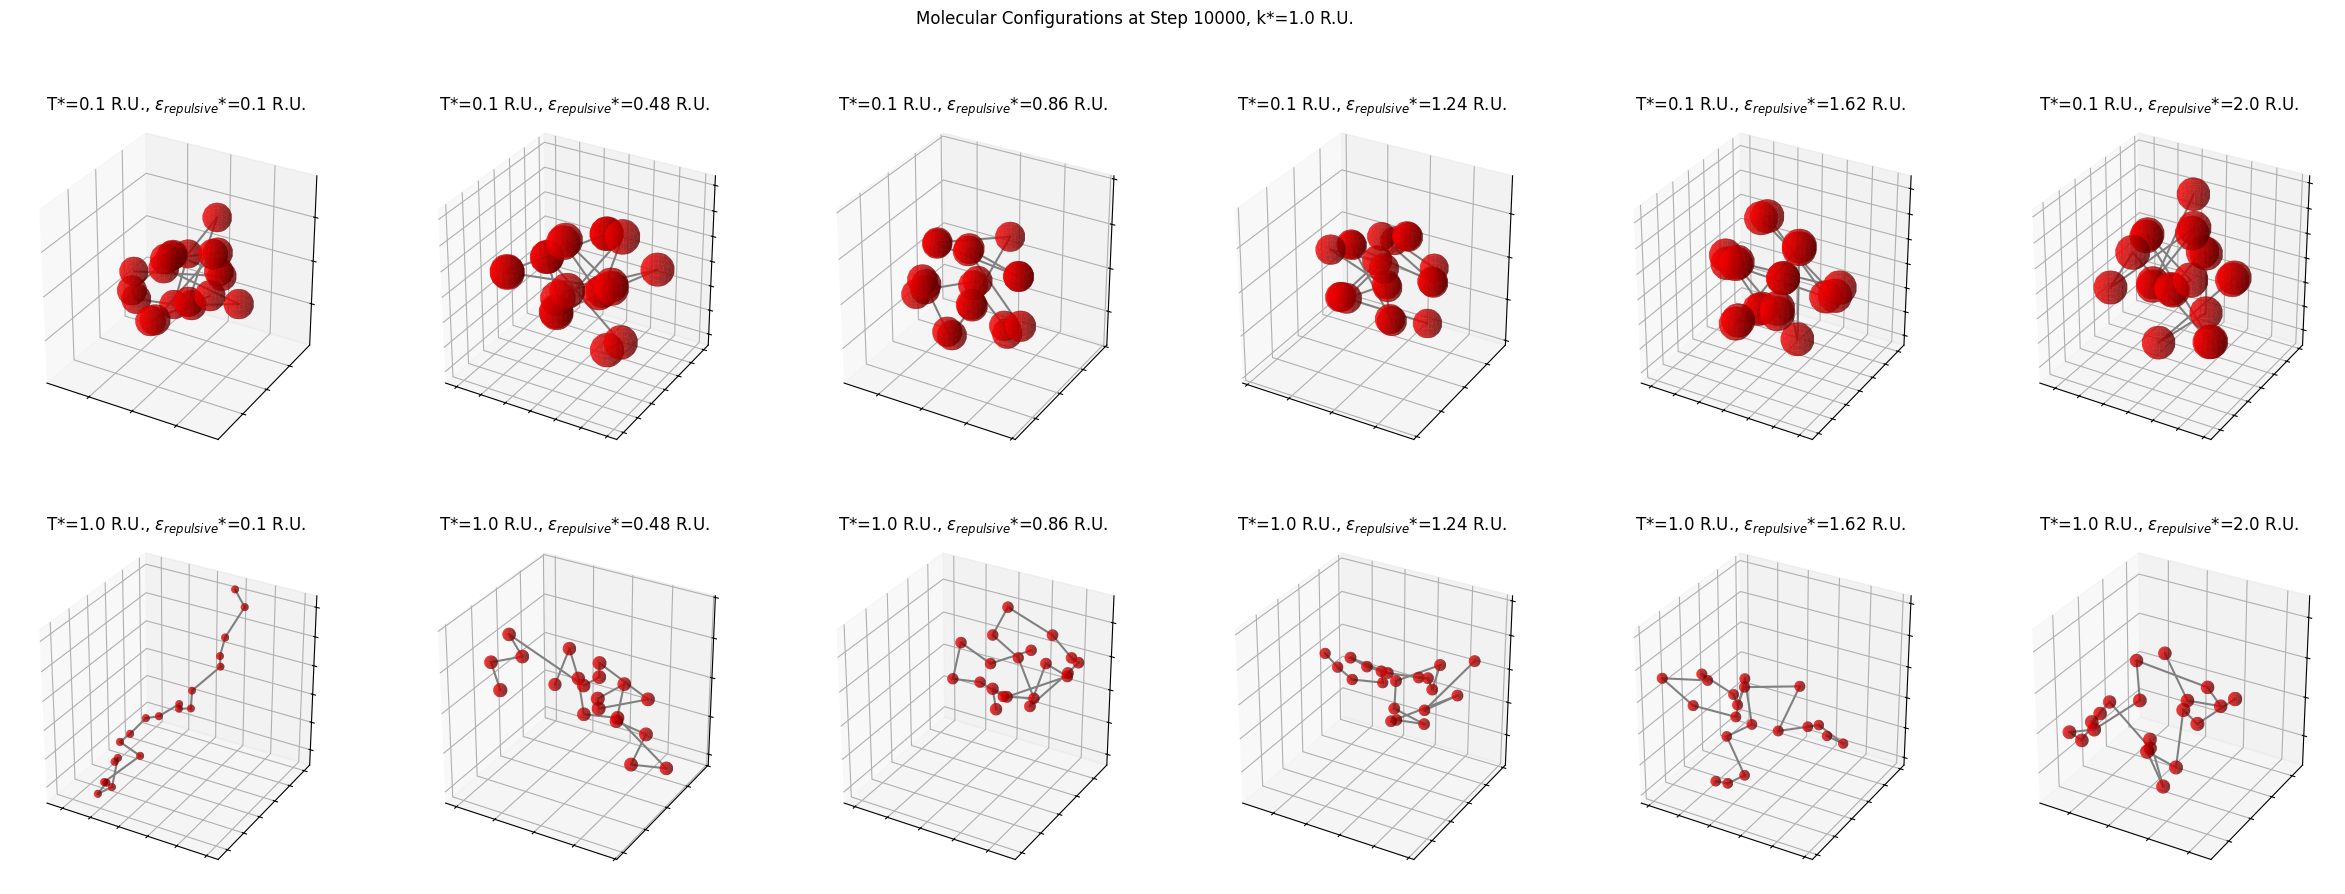

In [242]:
fig = plt.figure()
n_rows = 2
n_cols = 6
fig.set_size_inches(n_cols*5, n_rows*5)
p = 0
for i, row in u1_df.iterrows():
    p += 1
    u = row.u
    u.center()
    u.set_step(-1)
    ax = fig.add_subplot(n_rows, n_cols, p, projection='3d')
    u.plot(ax, size=0.1, title=rf'T*={row.temp} R.U., $\epsilon_{{repulsive}}$*={row.epsilon_repulsive} R.U.')
fig.suptitle("Molecular Configurations at Step 10000, k*=1.0 R.U.")
plt.tight_layout()
fig.savefig('plots/visualization_vary_er.png', dpi=210)

C:\Users\repti\AppData\Local\Temp\ipykernel_8360\3485416200.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


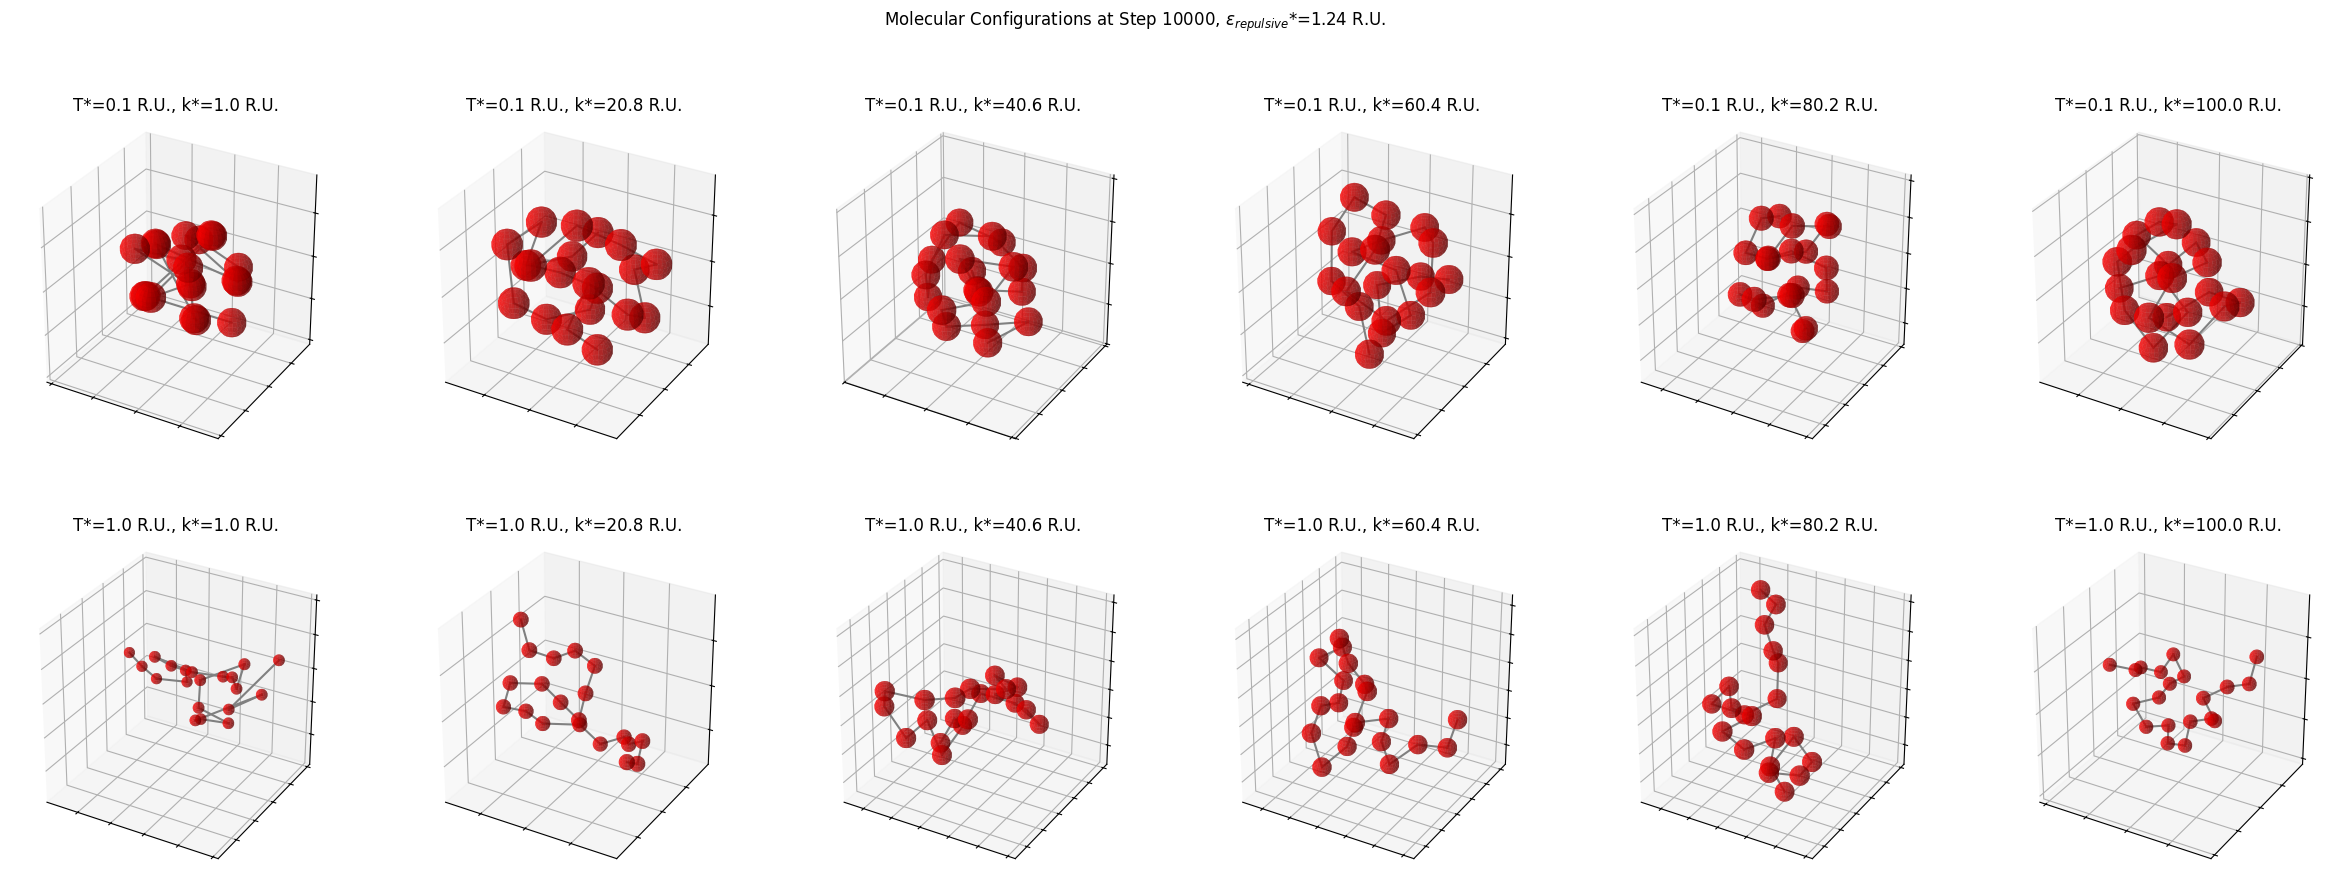

In [243]:
u1_df = uni_df.query('temp==0.1 and epsilon_repulsive==1.24 and batch==0')
u1_df = pd.concat([u1_df, uni_df.query('temp==1.0 and epsilon_repulsive==1.24 and batch==0')])
fig = plt.figure()
n_rows = 2
n_cols = 6
fig.set_size_inches(n_cols*5, n_rows*5)
p = 0
for i, row in u1_df.iterrows():
    p += 1
    u = row.u
    u.center()
    u.set_step(-1)
    ax = fig.add_subplot(n_rows, n_cols, p, projection='3d')
    u.plot(ax, size=0.1, title=rf'T*={row.temp} R.U., k*={row.k} R.U.')
fig.suptitle(r"Molecular Configurations at Step 10000, $\epsilon_{repulsive}$*=1.24 R.U.")
plt.tight_layout()
fig.savefig('plots/visualization_vary_k.png', dpi=210)

## Drop unphysical results

In [37]:
n = 20
a = 100
all_params = np.array(list(product(temps, ks, epsilon_repulsives, batches)))
uni_df_2 = pd.DataFrame({
    'temp': all_params[:, 0],
    'k': all_params[:, 1],
    'epsilon_repulsive': all_params[:, 2],
    'batch': all_params[:, 3]
})
uni_df_2['batch'] = uni_df_2['batch'].astype(int)
uni_df_2['u'] = uni_df_2.apply(
    lambda row: load_universe(n, a, row.k, row.epsilon_repulsive, row.temp, row.batch),
    axis=1
)
uni_df_2['u'].apply(lambda x: x.center())
uni_df_2

temp      k  epsilon_repulsive  batch  \
0     0.1    1.0               0.10      0   
1     0.1    1.0               0.10      1   
2     0.1    1.0               0.10      2   
3     0.1    1.0               0.48      0   
4     0.1    1.0               0.48      1   
..    ...    ...                ...    ...   
643   1.0  100.0               1.62      1   
644   1.0  100.0               1.62      2   
645   1.0  100.0               2.00      0   
646   1.0  100.0               2.00      1   
647   1.0  100.0               2.00      2   

                                                    u  
0    <__main__.Universe object at 0x0000025EE74288C0>  
1    <__main__.Universe object at 0x0000025EEAF45F10>  
2    <__main__.Universe object at 0x0000025EE9F6B950>  
3    <__main__.Universe object at 0x0000025EE9F68D70>  
4    <__main__.Universe object at 0x0000025EE95AD0D0>  
..                                                ...  
643  <__main__.Universe object at 0x0000025EEC549400>  
644  <__main__.Universe object at 0x0000025EEC549550>  
645  <__main__.Universe object at 0x0000025EEC5496A0>  
646  <__main__.Universe object at 0x0000025EEC549820>  
647  <__main__.Universe object at 0x0000025EEC549970>  

[648 rows x 5 columns]

In [194]:
def cleanse(u, steps):
    """
    Flags the systems with chain length greater than half the length of the box diagonal,
    or those whose center of geometry doesn't sit at the center of the box
    (indicates secondary wrapping after centering)

    Parameters:
        steps: list of steps to check
    """
    u.center()
    len_lim = np.linalg.norm(u.box.dim)/2
    for step in steps:
        u.set_step(step)
        max_dist = u.get_max_dist(mic=False)
        cent = u.box.get_centroid()
        if max_dist >= len_lim or np.any(np.round(cent, 1) != np.round(u.box.dim/2, 1)):
            return False
    return True

In [ ]:
steps = np.arange(951, 1001, dtype=int)
uni_df_2['valid'] = uni_df_2['u'].apply(lambda u: cleanse(u, steps))

In [303]:
uni_df['temp'] = uni_df['temp'].round(2)
uni_df['k'] = uni_df['k'].round(2)
uni_df['epsilon_repulsive'] = uni_df['epsilon_repulsive'].round(2)
uni_df_2['temp'] = uni_df_2['temp'].round(2)
uni_df_2['k'] = uni_df_2['k'].round(2)
uni_df_2['epsilon_repulsive'] = uni_df_2['epsilon_repulsive'].round(2)

In [39]:
uni_df_2.query('valid == False')

Empty DataFrame
Columns: [temp, k, epsilon_repulsive, batch, u, valid]
Index: []

In [42]:
uni_df = uni_df.merge(uni_df_2, on=['temp', 'k', 'epsilon_repulsive', 'batch']).drop(columns='u')
uni_df

temp      k  epsilon_repulsive  batch        Rg        Re         PE  \
0     0.1    1.0               0.10      0  1.087250  2.745282 -36.109590   
1     0.1    1.0               0.10      1  1.055093  2.272770 -36.999584   
2     0.1    1.0               0.10      2  1.050977  1.161705 -37.848285   
3     0.1    1.0               0.48      0  1.033539  1.964449 -39.002718   
4     0.1    1.0               0.48      1  1.055323  1.184700 -38.295526   
..    ...    ...                ...    ...       ...       ...        ...   
643   1.0  100.0               1.62      1  2.179350  4.196108   7.002401   
644   1.0  100.0               1.62      2  2.434229  5.027902   7.953218   
645   1.0  100.0               2.00      0  2.808171  6.327784   8.170254   
646   1.0  100.0               2.00      1  2.682843  6.382640   8.642857   
647   1.0  100.0               2.00      2  2.836413  7.536388   8.550454   

     valid  
0     True  
1     True  
2     True  
3     True  
4     True  
..     ...  
643   True  
644   True  
645   True  
646   True  
647   True  

[648 rows x 8 columns]

In [43]:
uni_df.to_csv('data/uni_df.csv', index=False)

In [244]:
uni_df = pd.read_csv('data/uni_df.csv')
uni_df = uni_df.query('valid')
uni_df

temp      k  epsilon_repulsive  batch        Rg        Re         PE  \
0     0.1    1.0               0.10      0  1.087250  2.745282 -36.109590   
1     0.1    1.0               0.10      1  1.055093  2.272770 -36.999584   
2     0.1    1.0               0.10      2  1.050977  1.161705 -37.848285   
3     0.1    1.0               0.48      0  1.033539  1.964449 -39.002718   
4     0.1    1.0               0.48      1  1.055323  1.184700 -38.295526   
..    ...    ...                ...    ...       ...       ...        ...   
643   1.0  100.0               1.62      1  2.179350  4.196108   7.002401   
644   1.0  100.0               1.62      2  2.434229  5.027902   7.953218   
645   1.0  100.0               2.00      0  2.808171  6.327784   8.170254   
646   1.0  100.0               2.00      1  2.682843  6.382640   8.642857   
647   1.0  100.0               2.00      2  2.836413  7.536388   8.550454   

     valid  
0     True  
1     True  
2     True  
3     True  
4     True  
..     ...  
643   True  
644   True  
645   True  
646   True  
647   True  

[648 rows x 8 columns]

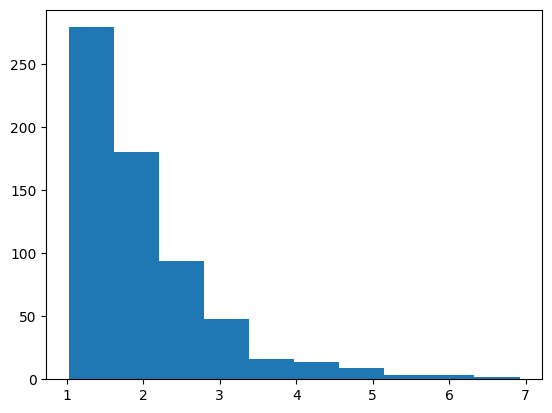

In [245]:
fig, ax = plt.subplots()
ax.hist(uni_df['Rg']);

In [246]:
uni_df_agg = uni_df.groupby(['temp', 'k', 'epsilon_repulsive'])[['Rg', 'Re', 'PE']].agg(['mean', 'std']).reset_index()
uni_df_agg

temp      k epsilon_repulsive        Rg                  Re            \
                                       mean       std      mean       std   
0    0.1    1.0              0.10  1.064440  0.019861  2.059919  0.812962   
1    0.1    1.0              0.48  1.051497  0.016383  1.690491  0.438534   
2    0.1    1.0              0.86  1.066771  0.010002  1.152522  0.027968   
3    0.1    1.0              1.24  1.060425  0.009125  1.711246  0.916505   
4    0.1    1.0              1.62  1.038824  0.015429  1.614306  0.418088   
..   ...    ...               ...       ...       ...       ...       ...   
211  1.0  100.0              0.48  2.230007  0.572610  4.893139  2.848282   
212  1.0  100.0              0.86  2.552124  0.919010  6.003725  3.421833   
213  1.0  100.0              1.24  2.266601  0.182238  5.078036  1.230311   
214  1.0  100.0              1.62  2.121606  0.345136  4.375217  0.584104   
215  1.0  100.0              2.00  2.775809  0.081740  6.748938  0.682503   

            PE            
          mean       std  
0   -36.985819  0.869429  
1   -38.318442  0.673110  
2   -37.927456  1.049594  
3   -37.990182  1.643572  
4   -40.101600  1.788244  
..         ...       ...  
211   5.664704  2.460551  
212   7.247600  1.340009  
213   5.892817  2.099377  
214   6.468800  1.811164  
215   8.454522  0.250481  

[216 rows x 9 columns]

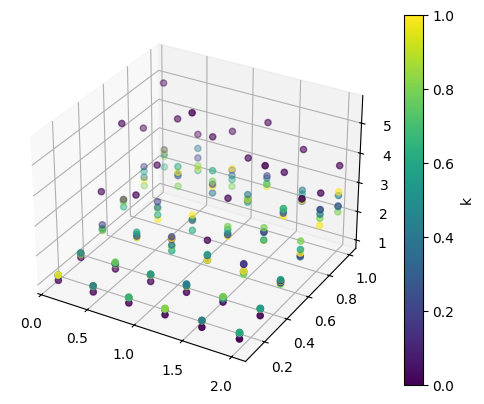

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = plt.get_cmap('viridis', len(uni_df_agg['k'].unique()))
cmap = {k: colors(i) for i, k in enumerate(uni_df_agg['k'].unique())}
hues = uni_df_agg['k'].apply(lambda x: cmap[x])
g = ax.scatter(uni_df_agg['epsilon_repulsive'], uni_df_agg['temp'], uni_df_agg['Rg']['mean'], color=hues)
plt.colorbar(g, ax=ax, location='right', fraction=0.1, label='k')

<Axes: xlabel='temp', ylabel='Rg'>

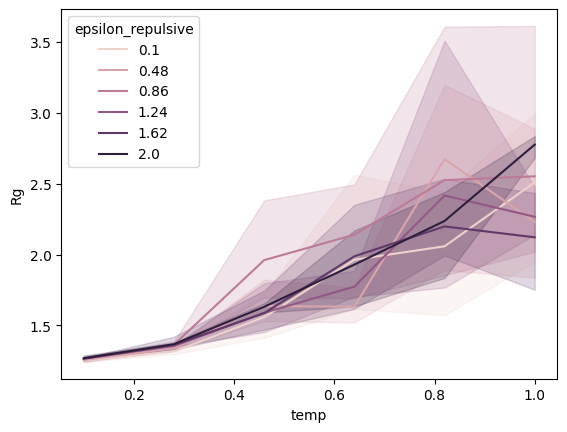

In [60]:
fig, ax = plt.subplots()
plot_df = uni_df.query('k==100.0').copy()
sns.lineplot(plot_df, x='temp', y='Rg', hue='epsilon_repulsive', ax=ax)

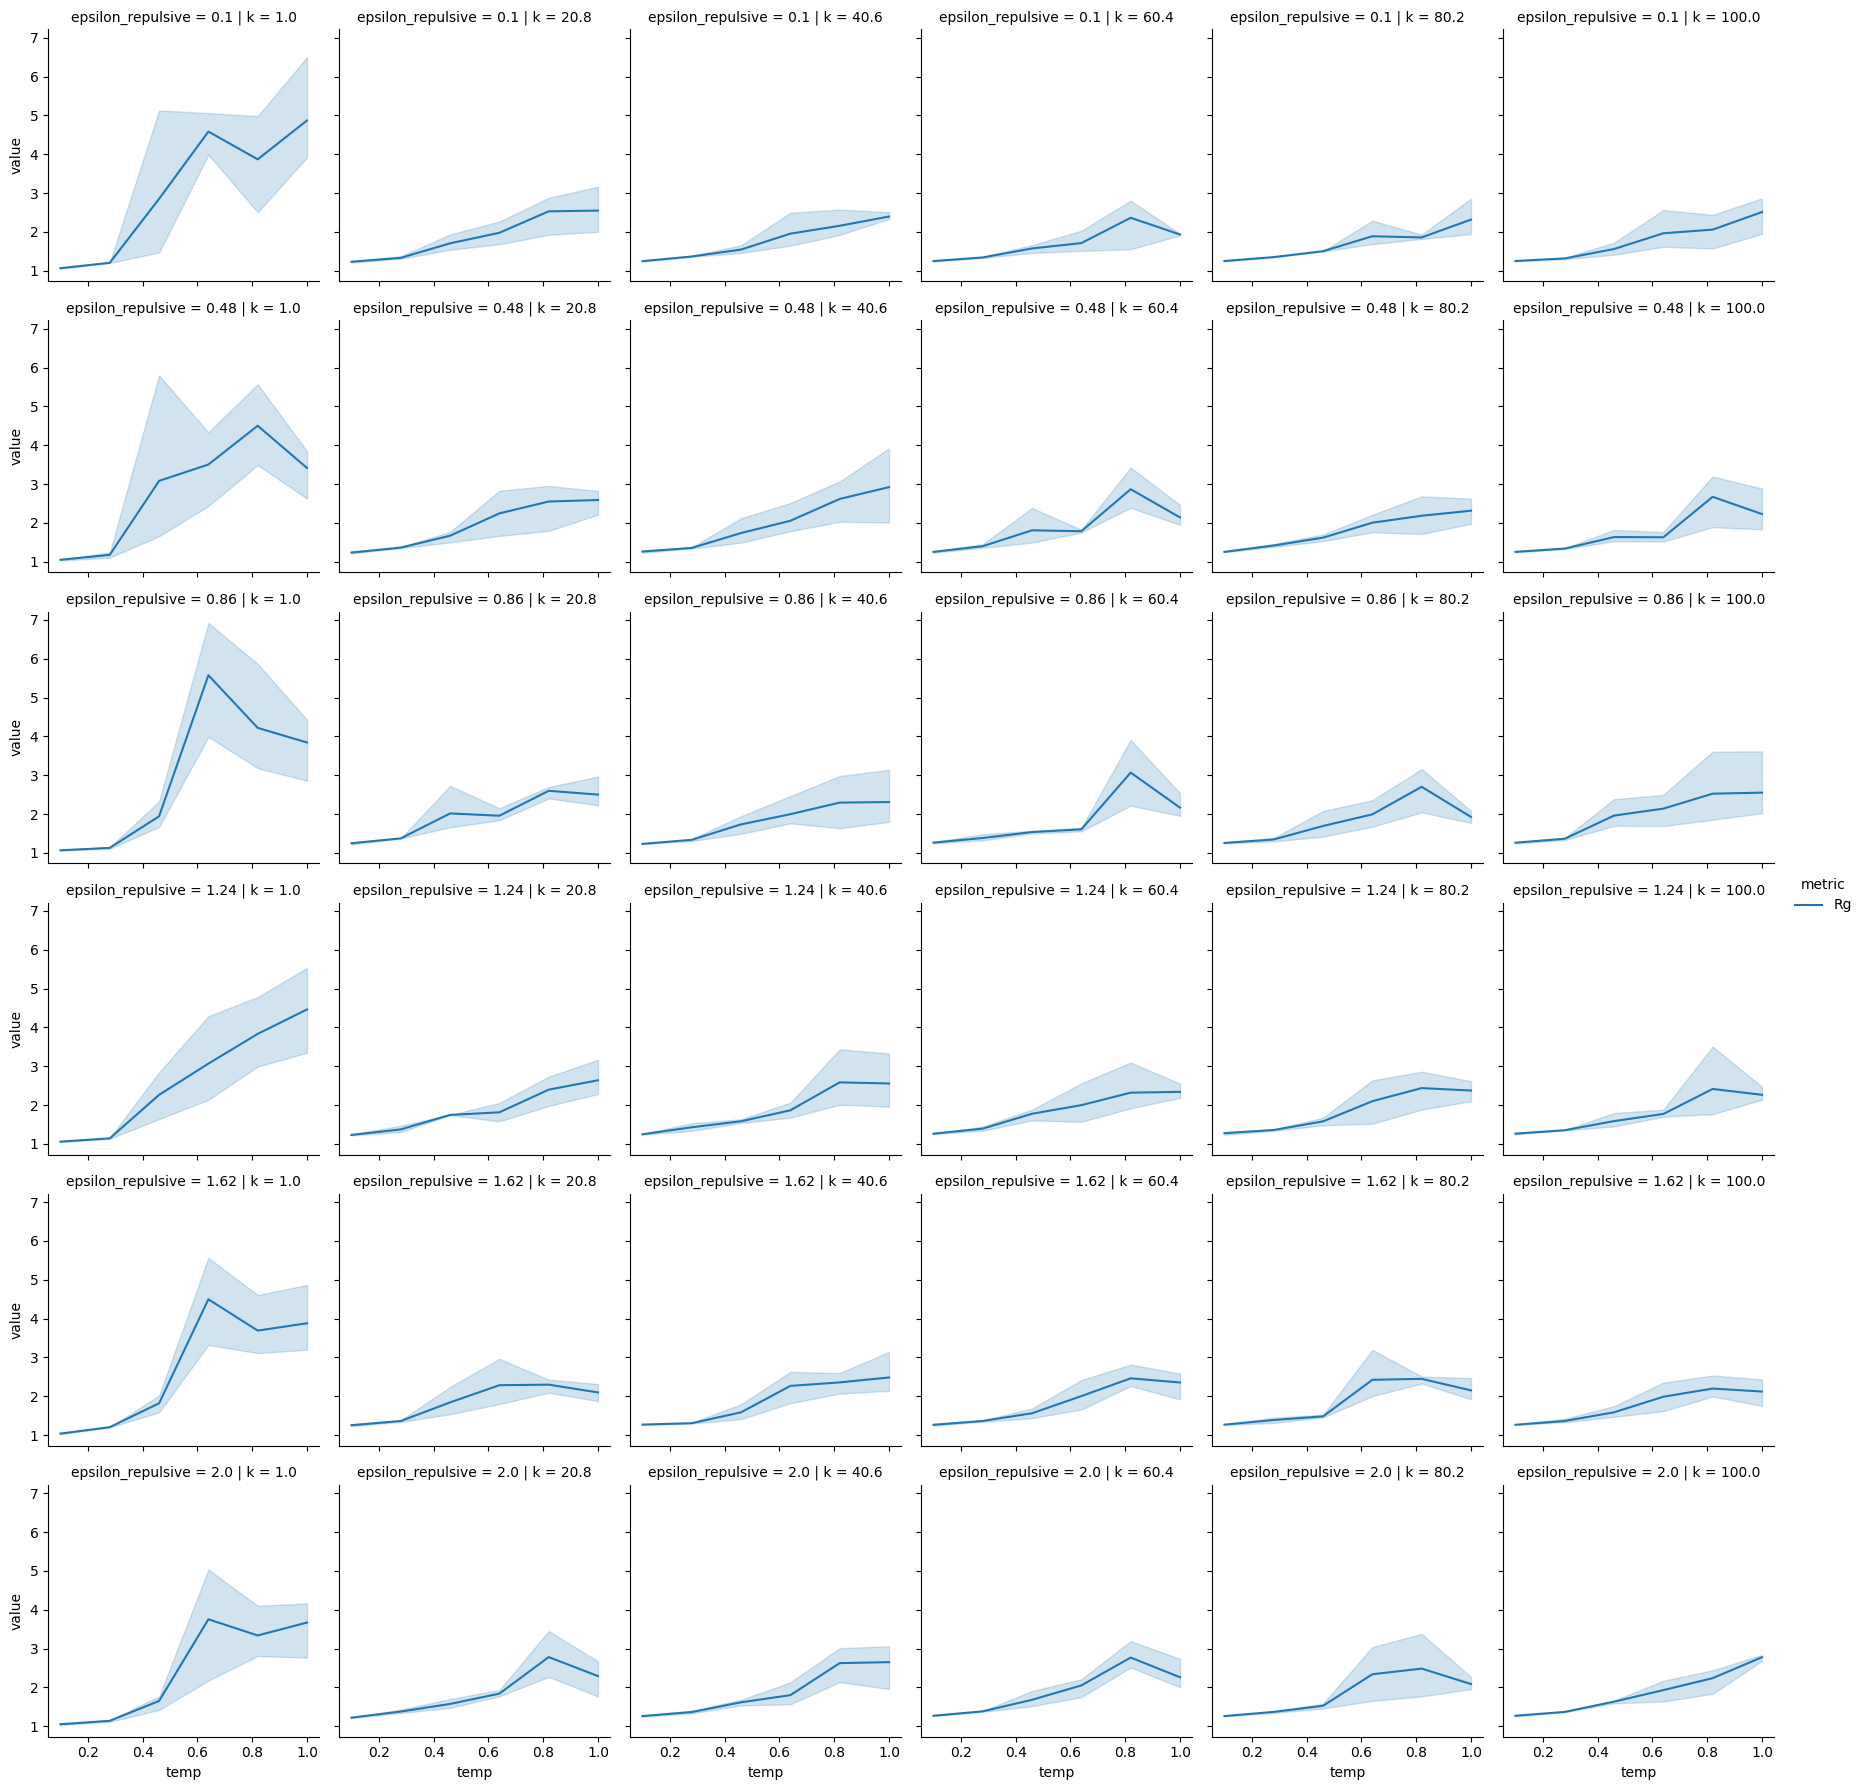

In [63]:
uni_df_long = uni_df.melt(id_vars=['epsilon_repulsive', 'k', 'temp', 'batch'], value_vars=['Rg'], var_name='metric', value_name='value')
g = sns.FacetGrid(
    uni_df_long, row='epsilon_repulsive', col='k', hue='metric'
)
g.map_dataframe(sns.lineplot, data=uni_df_long,  x='temp', y='value')
g.add_legend()

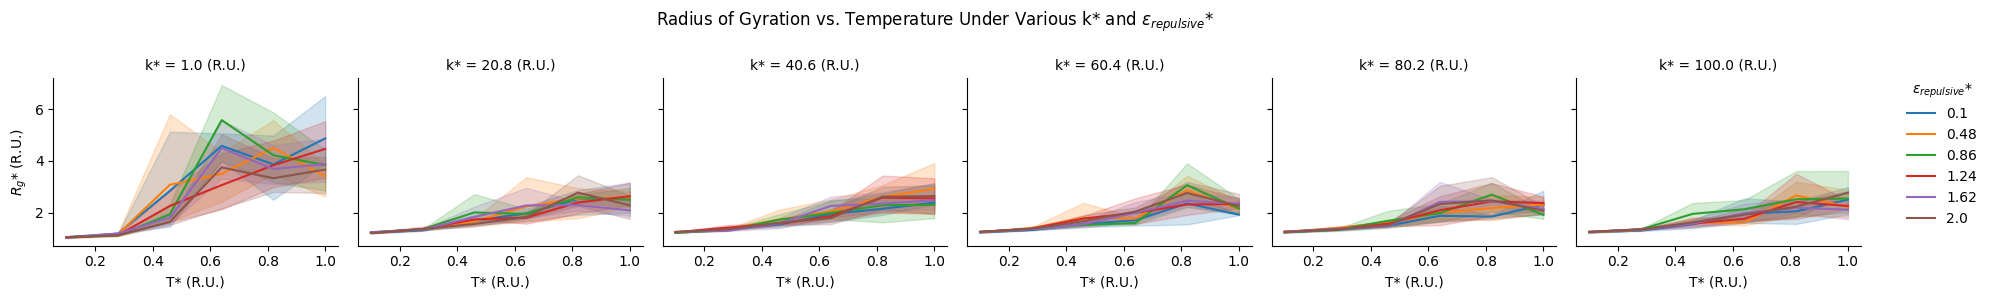

In [248]:
g = sns.FacetGrid(
    uni_df, col='k', hue='epsilon_repulsive'
)
g.map_dataframe(sns.lineplot, data=uni_df,  x='temp', y='Rg')
g.add_legend(
    title=r'$\epsilon_{repulsive}$*',
    loc='center left',
    bbox_to_anchor=(1.01, 0.5)
)
g.set_axis_labels("T* (R.U.)", "$R_g$* (R.U.)")
g.set_titles(col_template="k* = {col_name} (R.U.)")
g.fig.suptitle(r"Radius of Gyration vs. Temperature Under Various k* and $\epsilon_{repulsive}$*")
plt.tight_layout()
g.savefig("plots/rg_v_temp.png", dpi=210)

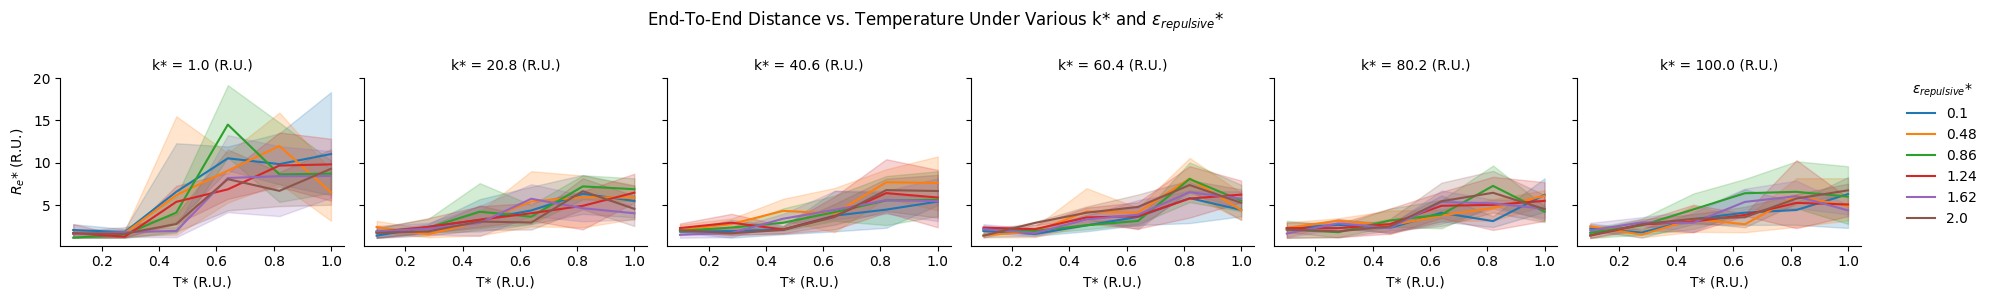

In [249]:
g = sns.FacetGrid(
    uni_df, col='k', hue='epsilon_repulsive'
)
g.map_dataframe(sns.lineplot, data=uni_df,  x='temp', y='Re')
g.add_legend(
    title=r'$\epsilon_{repulsive}$*',
    loc='center left',
    bbox_to_anchor=(1.01, 0.5)
)
g.set_axis_labels("T* (R.U.)", "$R_e$* (R.U.)")
g.set_titles(col_template="k* = {col_name} (R.U.)")
g.fig.suptitle(r"End-To-End Distance vs. Temperature Under Various k* and $\epsilon_{repulsive}$*")
plt.tight_layout()
g.savefig("plots/re_v_temp.png", dpi=210)

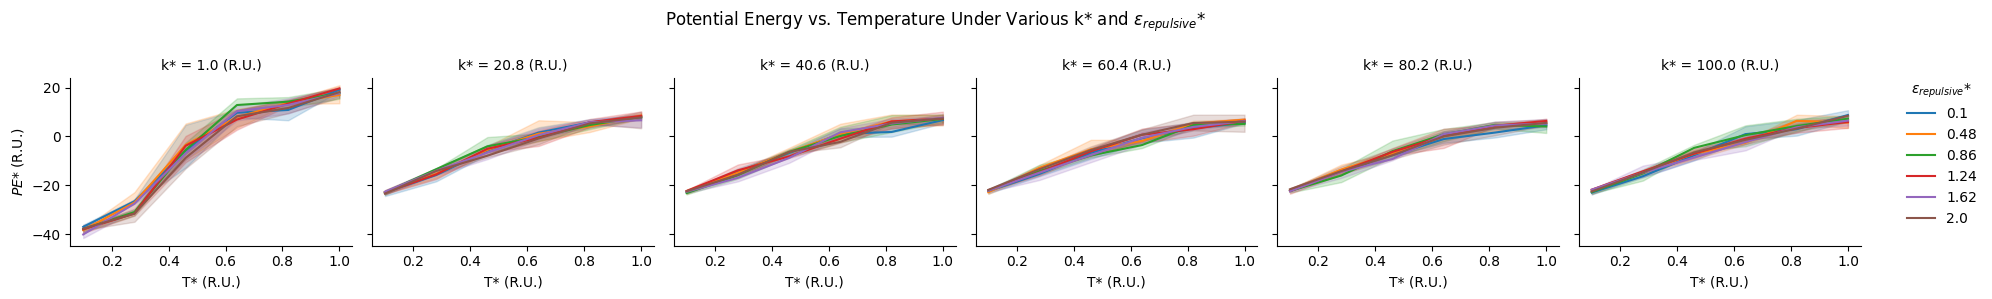

In [250]:
g = sns.FacetGrid(
    uni_df, col='k', hue='epsilon_repulsive'
)
g.map_dataframe(sns.lineplot, data=uni_df,  x='temp', y='PE')
g.add_legend(
    title=r'$\epsilon_{repulsive}$*',
    loc='center left',
    bbox_to_anchor=(1.01, 0.5)
)
g.set_axis_labels("T* (R.U.)", "$PE$* (R.U.)")
g.set_titles(col_template="k* = {col_name} (R.U.)")
g.fig.suptitle(r"Potential Energy vs. Temperature Under Various k* and $\epsilon_{repulsive}$*")
plt.tight_layout()
g.savefig("plots/pe_v_temp.png", dpi=210)

## Effect of chain length

In [275]:
temps = np.round(np.linspace(0.1, 1.0, 6), 2)
epsilon_repulsive = 1.24
k = 1.0
batches = np.array([0, 1, 2], dtype=int)
batch_2 = 1
ns = [5, 10, 40, 80]
a_s = [25, 50, 200, 400]
all_params = np.array(list(product(temps, np.array([5, 10, 20], dtype=int), batches)))
uni_df = pd.DataFrame({
    'temp': all_params[:, 0],
    'n': all_params[:, 1],
    'batch': all_params[:, 2]
})
all_params = np.array(list(product(temps, np.array([40, 80], dtype=int))))
uni_df = pd.concat([uni_df, pd.DataFrame({
    'temp': all_params[:, 0],
    'n': all_params[:, 1],
    'batch': 0
})], axis=0)
uni_df['n'] = uni_df['n'].astype(int)
uni_df['batch'] = uni_df['batch'].astype(int)
a_map = {5: 25, 10: 50, 20: 100, 40: 200, 80: 400}
uni_df['a'] = uni_df['n'].apply(lambda n: a_map[n]).astype(int)
uni_df.head()

temp   n  batch   a
0   0.1   5      0  25
1   0.1   5      1  25
2   0.1   5      2  25
3   0.1  10      0  50
4   0.1  10      1  50

In [276]:
uni_df['u'] = uni_df.apply(
    lambda row: load_universe(int(row.n), row.a, k, epsilon_repulsive, row.temp, row.batch),
    axis=1
)
uni_df['u'].apply(lambda x: x.center())
uni_df.head()

temp   n  batch   a                                                 u
0   0.1   5      0  25  <__main__.Universe object at 0x0000025E9D279BB0>
1   0.1   5      1  25  <__main__.Universe object at 0x0000025E8AD9C5C0>
2   0.1   5      2  25  <__main__.Universe object at 0x0000025E88DD9A30>
3   0.1  10      0  50  <__main__.Universe object at 0x0000025E97981D90>
4   0.1  10      1  50  <__main__.Universe object at 0x0000025E8726AD50>

C:\Users\repti\AppData\Local\Temp\ipykernel_8360\1400233653.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


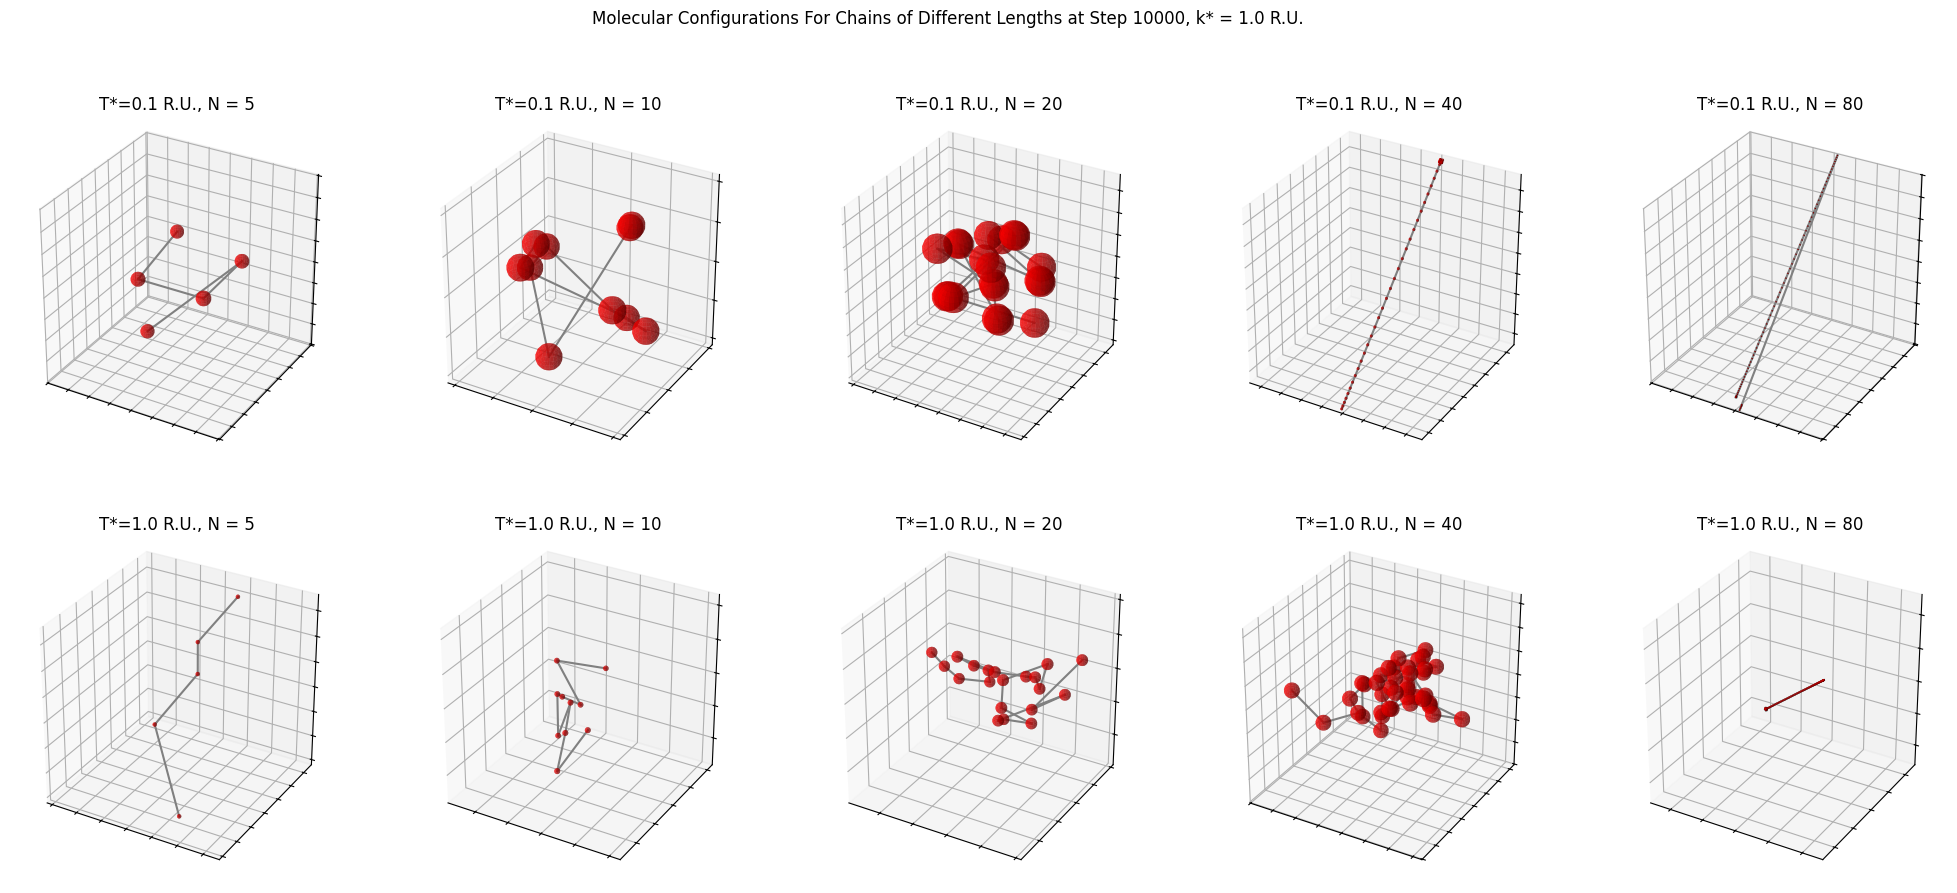

In [277]:
u1_df = uni_df.query('temp==0.1 and batch==0')
u1_df = pd.concat([u1_df, uni_df.query('temp==1.0 and batch==0')])
fig = plt.figure()
n_rows = 2
n_cols = 5
fig.set_size_inches(n_cols*5, n_rows*5)
p = 0
for i, row in u1_df.iterrows():
    p += 1
    u = row.u
    u.center()
    u.set_step(-1)
    ax = fig.add_subplot(n_rows, n_cols, p, projection='3d')
    u.plot(ax, size=0.1, title=rf'T*={row.temp} R.U., N = {row.n}')
fig.suptitle(r"Molecular Configurations For Chains of Different Lengths at Step 10000, k* = 1.0 R.U.")
plt.tight_layout()
fig.savefig('plots/visualization_vary_n_1-k.png', dpi=210)

In [122]:
steps = np.arange(951, 1001, dtype=int)
pbar = tqdm(total=len(uni_df)*3)
uni_df['Rg'] = uni_df['u'].apply(
    lambda u: average_properties(u.get_radius_of_gyration, u.set_step, steps, pbar)
)
uni_df['Re'] = uni_df['u'].apply(
    lambda u: average_properties(u.get_end_to_end_distance, u.set_step, steps, pbar)
)
uni_df['PE'] = uni_df['u'].apply(
    lambda u: average_properties(u.get_PE, u.set_step, steps, pbar)
)

  0%|          | 0/198 [00:00<?, ?it/s]

In [126]:
steps = np.arange(951, 1001, dtype=int)
pbar = tqdm(total=len(uni_df))
def cleanse_row(u):
    pbar.update(1)
    return cleanse(u, steps)
uni_df['valid'] = uni_df['u'].apply(cleanse_row)

  0%|          | 0/66 [00:00<?, ?it/s]

In [127]:
uni_df = uni_df.drop(columns='u')
uni_df

temp   n  batch    a          Rg          Re           PE  valid
0   0.10   5      0   25    0.902785    1.125026    -1.268575   True
1   0.10   5      1   25    0.910242    1.124792    -1.260107   True
2   0.10   5      2   25    0.889043    1.132294    -1.264908   True
3   0.10  10      0   50    0.836274    1.156645   -10.248149   True
4   0.10  10      1   50    0.852291    1.128575   -10.257690   True
..   ...  ..    ...  ...         ...         ...          ...    ...
7   0.64  80      0  400    2.369296    4.068333   -86.387717   True
8   0.82  40      0  200    3.804105    6.822916    21.384917   True
9   0.82  80      0  400    4.192754   15.022391     9.551139   True
10  1.00  40      0  200    3.834645    7.276933    32.308674   True
11  1.00  80      0  400  138.569553  367.635666  1048.946412  False

[66 rows x 8 columns]

In [128]:
uni_df.to_csv('data/uni_df_chain_length.csv', index=False)

In [251]:
uni_df = pd.read_csv('data/uni_df_chain_length.csv')
uni_df = uni_df[uni_df['valid']]
uni_df['n'] = uni_df['n'].astype('category')
uni_df

temp   n  batch    a        Rg         Re         PE  valid
0   0.10   5      0   25  0.902785   1.125026  -1.268575   True
1   0.10   5      1   25  0.910242   1.124792  -1.260107   True
2   0.10   5      2   25  0.889043   1.132294  -1.264908   True
3   0.10  10      0   50  0.836274   1.156645 -10.248149   True
4   0.10  10      1   50  0.852291   1.128575 -10.257690   True
..   ...  ..    ...  ...       ...        ...        ...    ...
60  0.64  40      0  200  2.674160   5.296057  -1.551306   True
61  0.64  80      0  400  2.369296   4.068333 -86.387717   True
62  0.82  40      0  200  3.804105   6.822916  21.384917   True
63  0.82  80      0  400  4.192754  15.022391   9.551139   True
64  1.00  40      0  200  3.834645   7.276933  32.308674   True

[63 rows x 8 columns]

In [252]:
uni_df['linear_rg'] = uni_df.apply(lambda row: 1/2/np.sqrt(3)*np.sqrt(row.n**2 - 1), axis=1)

In [253]:
uni_df['normalized_rg'] = uni_df.apply(lambda row: row.Rg/row.linear_rg, axis=1)

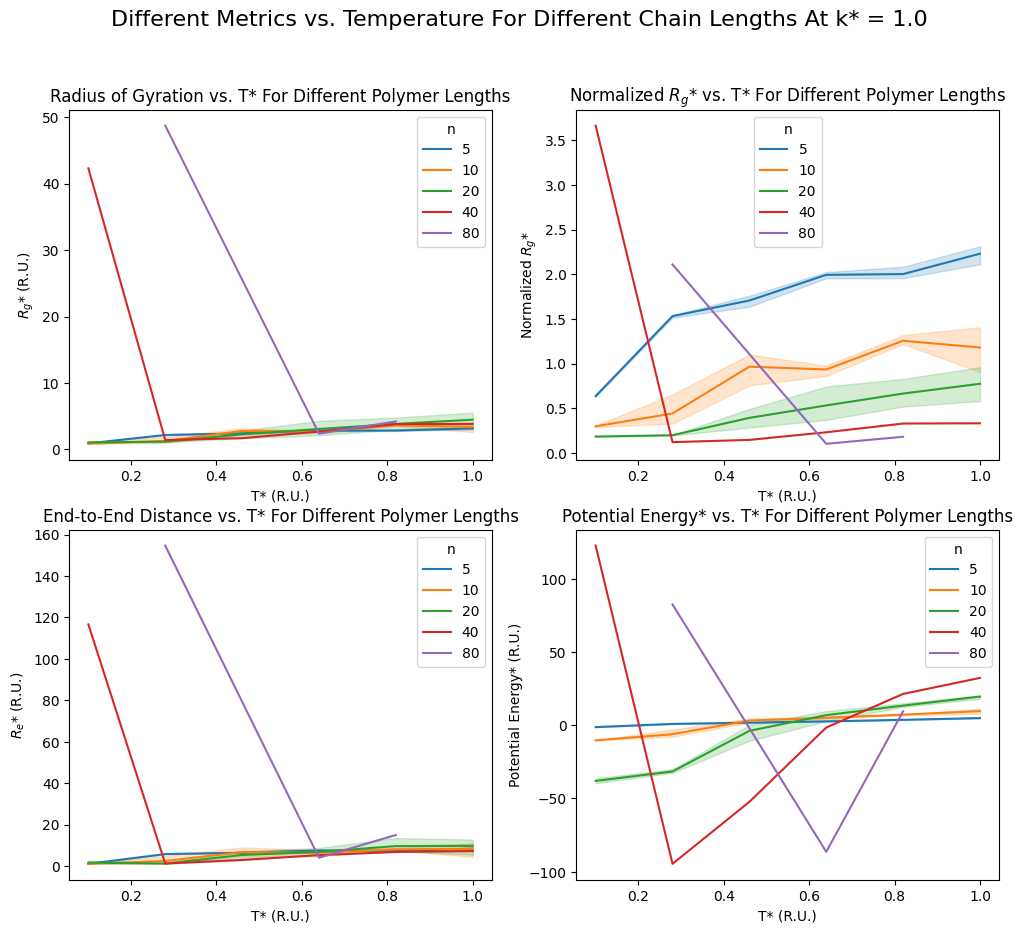

In [254]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
sns.lineplot(uni_df, x='temp', y='Rg', hue='n', ax=ax[0][0])
ax[0][0].set_title("Radius of Gyration vs. T* For Different Polymer Lengths")
ax[0][0].set_xlabel('T* (R.U.)'); ax[0][0].set_ylabel('$R_g$* (R.U.)')
sns.lineplot(uni_df, x='temp', y='normalized_rg', hue='n', ax=ax[0][1])
ax[0][1].set_title("Normalized $R_g$* vs. T* For Different Polymer Lengths")
ax[0][1].set_xlabel('T* (R.U.)'); ax[0][1].set_ylabel('Normalized $R_g$*')
sns.lineplot(uni_df, x='temp', y='Re', hue='n', ax=ax[1][0])
ax[1][0].set_title("End-to-End Distance vs. T* For Different Polymer Lengths")
ax[1][0].set_xlabel('T* (R.U.)'); ax[1][0].set_ylabel('$R_e$* (R.U.)')
sns.lineplot(uni_df, x='temp', y='PE', hue='n', ax=ax[1][1])
ax[1][1].set_title("Potential Energy* vs. T* For Different Polymer Lengths")
ax[1][1].set_xlabel('T* (R.U.)'); ax[1][1].set_ylabel('Potential Energy* (R.U.)')
fig.suptitle("Different Metrics vs. Temperature For Different Chain Lengths At k* = 1.0", fontsize=16)
fig.savefig('plots/n_temp_1_k.png', dpi=210, bbox_inches='tight')

In [279]:
temps = np.round(np.linspace(0.1, 1.0, 6), 2)
epsilon_repulsive = 1.24
k = 100.0
batches = np.array([0, 1, 2], dtype=int)
batch_2 = 1
ns = [5, 10, 40, 80]
a_s = [25, 50, 200, 400]
all_params = np.array(list(product(temps, np.array([5, 10, 20], dtype=int), batches)))
uni_df = pd.DataFrame({
    'temp': all_params[:, 0],
    'n': all_params[:, 1],
    'batch': all_params[:, 2]
})
all_params = np.array(list(product(temps, np.array([40, 80], dtype=int))))
uni_df = pd.concat([uni_df, pd.DataFrame({
    'temp': all_params[:, 0],
    'n': all_params[:, 1],
    'batch': 0
})], axis=0)
uni_df['n'] = uni_df['n'].astype(int)
uni_df['batch'] = uni_df['batch'].astype(int)
a_map = {5: 25, 10: 50, 20: 100, 40: 200, 80: 400}
uni_df['a'] = uni_df['n'].apply(lambda n: a_map[n]).astype(int)
uni_df.head()

temp   n  batch   a
0   0.1   5      0  25
1   0.1   5      1  25
2   0.1   5      2  25
3   0.1  10      0  50
4   0.1  10      1  50

In [280]:
uni_df['u'] = uni_df.apply(
    lambda row: load_universe(int(row.n), row.a, k, epsilon_repulsive, row.temp, row.batch),
    axis=1
)
uni_df['u'].apply(lambda x: x.center())
uni_df.head()

temp   n  batch   a                                                 u
0   0.1   5      0  25  <__main__.Universe object at 0x0000025E94A49FD0>
1   0.1   5      1  25  <__main__.Universe object at 0x0000025E8B1CB2F0>
2   0.1   5      2  25  <__main__.Universe object at 0x0000025E86C525D0>
3   0.1  10      0  50  <__main__.Universe object at 0x0000025E9B62A870>
4   0.1  10      1  50  <__main__.Universe object at 0x0000025E9B62ACF0>

C:\Users\repti\AppData\Local\Temp\ipykernel_8360\3198422843.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


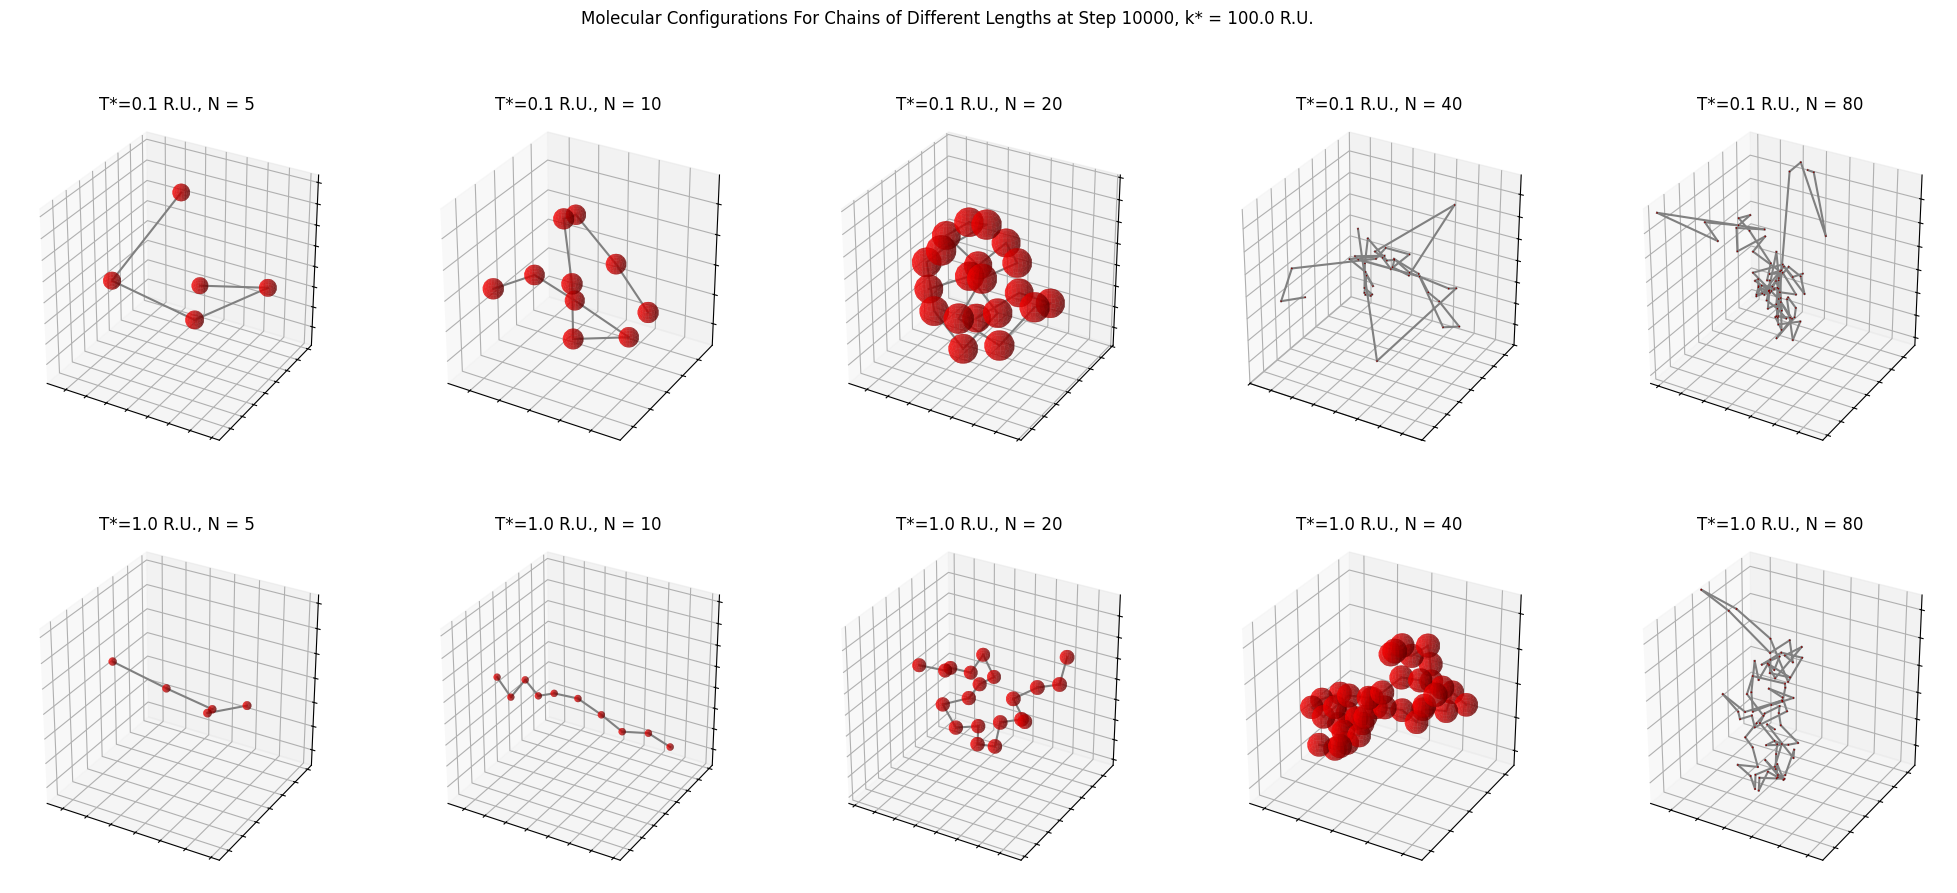

In [274]:
u1_df = uni_df.query('temp==0.1 and batch==0')
u1_df = pd.concat([u1_df, uni_df.query('temp==1.0 and batch==0')])
fig = plt.figure()
n_rows = 2
n_cols = 5
fig.set_size_inches(n_cols*5, n_rows*5)
p = 0
for i, row in u1_df.iterrows():
    p += 1
    u = row.u
    u.center()
    u.set_step(-1)
    ax = fig.add_subplot(n_rows, n_cols, p, projection='3d')
    u.plot(ax, size=0.1, title=rf'T*={row.temp} R.U., N = {row.n}')
fig.suptitle(r"Molecular Configurations For Chains of Different Lengths at Step 10000, k* = 100.0 R.U.")
plt.tight_layout()
fig.savefig('plots/visualization_vary_n_100-k.png', dpi=210)

In [295]:
anim_u = uni_df.query('temp==1.0 and n==40 and batch==0').iloc[0].u
anim_u.center()
anim_u.set_step(0)
anim_u

In [296]:
anim_u.n_frames

1001

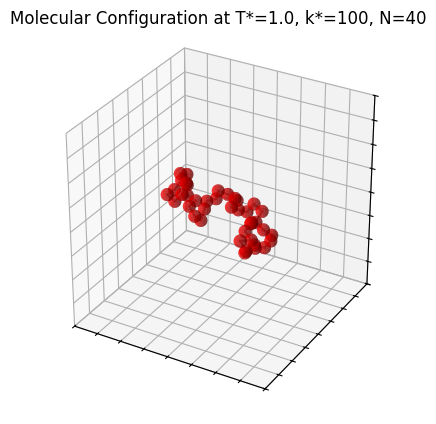

In [299]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
anim_u.plot(ax, size=0.1, title="Molecular Configuration at T*=1.0, k*=100, N=40", xlim=(90, 110))

In [303]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

progress_bar = tqdm(total=1001, desc="Animating")
def update(frame):
    progress_bar.update(1)
    anim_u.set_step(frame)
    ax.clear()
    anim_u.plot(ax, size=0.1, title="Molecular Configuration at T*=1.0, k*=100, N=40", xlim=(90, 110))
    return ax

anim = animation.FuncAnimation(fig, update, frames=1001, blit=False)
anim.save('1-t-100-k-40-n_animation.gif', fps=20, dpi=200)
plt.close(fig)

Animating:   0%|          | 0/1001 [00:00<?, ?it/s]

In [195]:
steps = np.arange(951, 1001, dtype=int)
pbar = tqdm(total=len(uni_df)*3)
uni_df['Rg'] = uni_df['u'].apply(
    lambda u: average_properties(u.get_radius_of_gyration, u.set_step, steps, pbar)
)
uni_df['Re'] = uni_df['u'].apply(
    lambda u: average_properties(u.get_end_to_end_distance, u.set_step, steps, pbar)
)
uni_df['PE'] = uni_df['u'].apply(
    lambda u: average_properties(u.get_PE, u.set_step, steps, pbar)
)

  0%|          | 0/198 [00:00<?, ?it/s]

In [196]:
steps = np.arange(951, 1001, dtype=int)
pbar = tqdm(total=len(uni_df))
def cleanse_row(u):
    pbar.update(1)
    return cleanse(u, steps)
uni_df['valid'] = uni_df['u'].apply(cleanse_row)

  0%|          | 0/66 [00:00<?, ?it/s]

In [197]:
uni_df = uni_df.drop(columns='u')
uni_df.to_csv('data/uni_df_chain_length_100_k.csv', index=False)

In [263]:
uni_df = pd.read_csv('data/uni_df_chain_length_100_k.csv')
uni_df = uni_df[uni_df['valid']]
uni_df['n'] = uni_df['n'].astype('category')
uni_df

temp   n  batch    a        Rg         Re         PE  valid
0   0.10   5      0   25  0.743112   1.129536  -1.343466   True
1   0.10   5      1   25  0.748745   1.131918  -1.329724   True
2   0.10   5      2   25  0.747871   1.157266  -1.363338   True
3   0.10  10      0   50  0.981211   2.089403  -7.018123   True
4   0.10  10      1   50  1.044038   1.153315  -6.222938   True
5   0.10  10      2   50  1.008650   2.613033  -6.896385   True
6   0.10  20      0  100  1.250944   1.107852 -21.990148   True
7   0.10  20      1  100  1.283516   1.144405 -21.390168   True
8   0.10  20      2  100  1.263351   1.931523 -21.982009   True
9   0.28   5      0   25  1.123506   2.903164   0.306370   True
10  0.28   5      1   25  1.015352   2.510001   0.158319   True
11  0.28   5      2   25  1.051265   2.590002   0.073482   True
12  0.28  10      0   50  1.094947   2.027114  -5.002891   True
13  0.28  10      1   50  1.133106   1.502495  -3.285128   True
14  0.28  10      2   50  1.167471   1.227470  -3.044684   True
15  0.28  20      0  100  1.350629   2.946650 -13.889173   True
16  0.28  20      1  100  1.355682   3.111693 -14.009323   True
17  0.28  20      2  100  1.359438   2.067262 -14.982918   True
18  0.46   5      0   25  1.094955   2.615951   0.612620   True
19  0.46   5      1   25  1.022977   2.348548   0.480403   True
20  0.46   5      2   25  1.166936   2.990854   0.475107   True
21  0.46  10      0   50  2.001709   5.190244   1.254671   True
22  0.46  10      1   50  1.295245   1.953309   0.113486   True
23  0.46  10      2   50  1.852235   5.378782   0.372489   True
24  0.46  20      0  100  1.452717   1.792129  -8.827667   True
25  0.46  20      1  100  1.797844   5.046085  -4.987774   True
26  0.46  20      2  100  1.517715   2.350777  -7.278151   True
27  0.64   5      0   25  1.166440   3.134245   0.579036   True
28  0.64   5      1   25  1.295959   3.574095   0.548214   True
29  0.64   5      2   25  0.948893   1.800876   0.485825   True
30  0.64  10      0   50  1.855535   4.853746   2.341634   True
31  0.64  10      1   50  1.427413   3.629451   0.636532   True
32  0.64  10      2   50  1.398242   3.004670   0.673190   True
33  0.64  20      0  100  1.733998   4.008914  -1.816508   True
34  0.64  20      1  100  1.702371   3.737809  -0.103263   True
35  0.64  20      2  100  1.884865   3.762473  -0.857737   True
36  0.82   5      0   25  1.151715   2.858493   0.769032   True
37  0.82   5      1   25  1.222539   3.221482   0.864846   True
38  0.82   5      2   25  1.261087   3.222449   0.518678   True
39  0.82  10      0   50  1.823665   4.595914   4.251474   True
40  0.82  10      1   50  2.034446   5.565179   4.387550   True
41  0.82  10      2   50  1.319804   1.541911  -0.000348   True
42  0.82  20      0  100  3.509536  10.315105   6.554395   True
43  0.82  20      1  100  1.766980   2.274364   0.636136   True
44  0.82  20      2  100  1.973321   3.198880   3.290863   True
45  1.00   5      0   25  1.191575   3.089764   0.868660   True
46  1.00   5      1   25  1.376650   3.826112   0.828034   True
47  1.00   5      2   25  1.285562   3.462601   1.287327   True
48  1.00  10      0   50  2.268772   6.603652   2.603843   True
49  1.00  10      1   50  1.597533   3.770808   2.356070   True
50  1.00  10      2   50  1.395592   2.870522   5.427927   True
51  1.00  20      0  100  2.475553   5.511690   7.422804   True
52  1.00  20      1  100  2.183688   6.032799   3.499408   True
53  1.00  20      2  100  2.140561   3.689618   6.756239   True
56  0.28  40      0  200  1.707734   2.260277 -41.488770   True
60  0.64  40      0  200  2.492216   2.555905 -11.259126   True
61  0.64  80      0  400  2.638408   5.512565 -45.566316   True
62  0.82  40      0  200  2.348045   4.699753  -3.368496   True
63  0.82  80      0  400  3.185400   7.843561 -16.650472   True
64  1.00  40      0  200  2.721965   4.301681   5.309419   True

In [264]:
uni_df['linear_rg'] = uni_df.apply(lambda row: 1/2/np.sqrt(3)*np.sqrt(row.n**2 - 1), axis=1)

In [265]:
uni_df['normalized_rg'] = uni_df.apply(lambda row: row.Rg/row.linear_rg, axis=1)

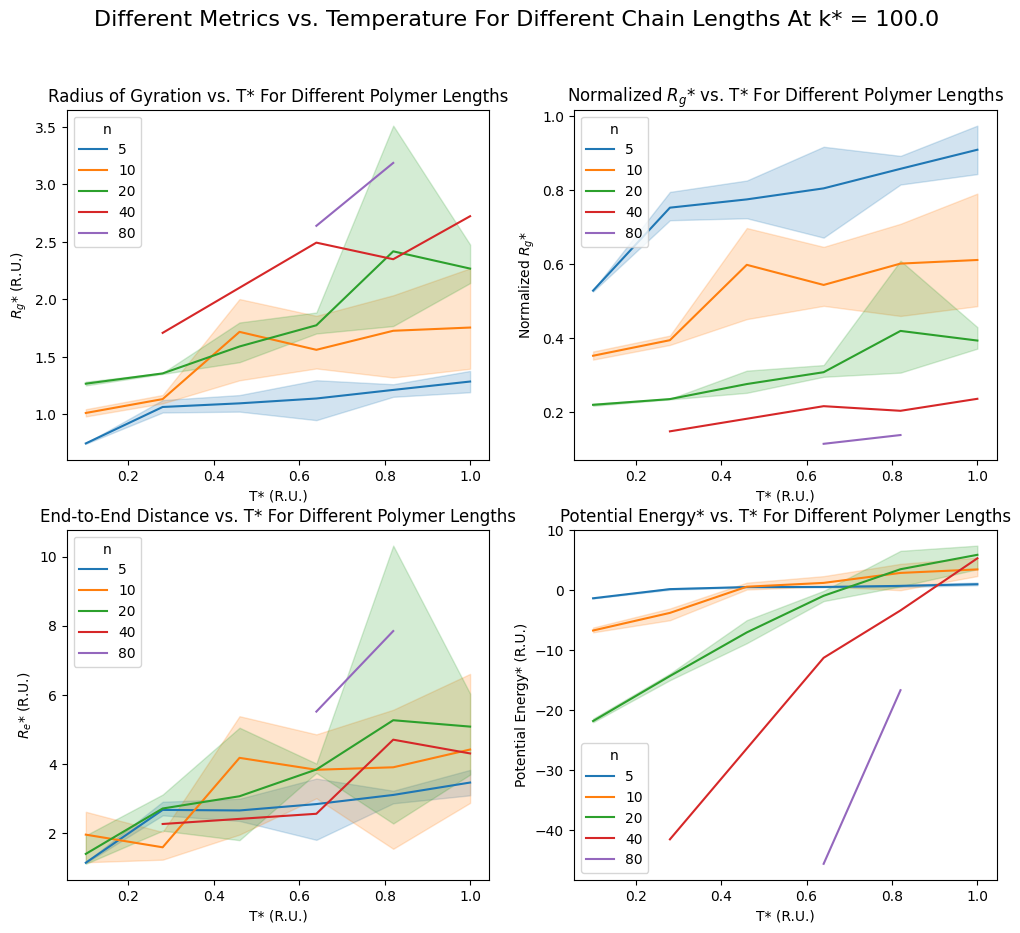

In [266]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
sns.lineplot(uni_df, x='temp', y='Rg', hue='n', ax=ax[0][0])
ax[0][0].set_title("Radius of Gyration vs. T* For Different Polymer Lengths")
ax[0][0].set_xlabel('T* (R.U.)'); ax[0][0].set_ylabel('$R_g$* (R.U.)')
sns.lineplot(uni_df, x='temp', y='normalized_rg', hue='n', ax=ax[0][1])
ax[0][1].set_title("Normalized $R_g$* vs. T* For Different Polymer Lengths")
ax[0][1].set_xlabel('T* (R.U.)'); ax[0][1].set_ylabel('Normalized $R_g$*')
sns.lineplot(uni_df, x='temp', y='Re', hue='n', ax=ax[1][0])
ax[1][0].set_title("End-to-End Distance vs. T* For Different Polymer Lengths")
ax[1][0].set_xlabel('T* (R.U.)'); ax[1][0].set_ylabel('$R_e$* (R.U.)')
sns.lineplot(uni_df, x='temp', y='PE', hue='n', ax=ax[1][1])
ax[1][1].set_title("Potential Energy* vs. T* For Different Polymer Lengths")
ax[1][1].set_xlabel('T* (R.U.)'); ax[1][1].set_ylabel('Potential Energy* (R.U.)')
fig.suptitle("Different Metrics vs. Temperature For Different Chain Lengths At k* = 100.0", fontsize=16)

fig.savefig('plots/n_temp_100_k.png', dpi=210, bbox_inches='tight')

# Integration into MDAnalysis

In [54]:
import MDAnalysis as mda
import nglview as nv

In [13]:
u = mda.Universe("topology/chain0.psf", "trajectory/chain0.xyz")

In [14]:
view = nv.show_mdanalysis(u)
view

NGLWidget(max_frame=8)

In [55]:
def load_mda(n, a, k, epsilon_repulsive, temp):
    file_prefix = f"chain_{n}-atoms_{k}-spring_{epsilon_repulsive}-er_{temp}"
    u = mda.Universe(
        f"topology/{file_prefix}.psf",
        f"trajectory/{file_prefix}.xyz"
    )
    return u

In [69]:
u = load_mda(n, a, ks[0], epsilon_repulsives[-1], temps[-1])
view = nv.show_mdanalysis(u)
view

NGLWidget(max_frame=999)

In [58]:
u.bonds

<TopologyGroup containing 19 bonds>